# Title of the Project

!!! **The Neural Ear: Unearth the Composer of your Music** !!!

## Author Details

- **Name:** Ravi Teja Kothuru
- **Course Code:** AAI-511-IN2
- **Course Name:** Neural Networks and Deep Learning
- University of San Diego
- **Instructor:** Prof. Anamika Singh
- **Date:** 11th August 2025

**Description:** The goal of this project is to create a deep-learning-based system that can classify the musical composer of the musical score. The project will only explore four well-known individuals in Western classical music - `Bach`, `Beethoven`, `Chopin`, and `Mozart`!

**Objectives:** The project will utilize the midi_classic_music dataset available from Kaggle that hosted 3929 midi files of classical musical scores with 175 different composers including Bach, Beethoven, Mozart, Brahms, Chopin, Tschaikovsky, Strauss, Stravinski, Prokofiev, Rachmaninov, Bernstein, Bartok, Handel, Ravel, Scriabin, etc. The challenge will be to build a good classification model with two state-of-the-art deep learning models:  Convolution Neural Networks (CNN) and Long Short-Term Memory Networks (LSTM) as these two models were chosen for their ability to learn spatial patterns and temporal patterns from music.

> The MIDI file is not an audio recording. Rather, it’s a recipe to an audio that explains what notes to play, when to play etc. It is a set of instructions such as pitch, note, tempo etc., that contain musical performance data used for electronic music production.

**Data Source:** Kaggle - https://www.kaggle.com/datasets/blanderbuss/midi-classic-music/data 

> As mentioned in the Dataset description in Kaggle, it contains 3929 midi files of classical works by 175 composers including Bach, Beethoven, Mozart, Brahms, Chopin, Tchaikovsky, Strauss, Stravinski, Prokofiev, Rachmaninov, Bernstein, Bartok, Handel, Ravel, Scriabin, and others.

**Number of Variables:** Because the dataset is MIDI, and thus not a tabular CSV, there are not "columns" or "variables" to speak of. Rather, the information is encoded in the MIDI format, and from the MIDI files, the following features can be extracted:
    - Note pitch values
    - Note onset (start time) and offset (duration)
    - Tempo
    - Velocity (intensity of note)
    - Time signature & key signature (when available)
    - Chord progressions and patterns

The class label (i.e. composer name) is typically inferred from the file name or folder structure of each MIDI file.
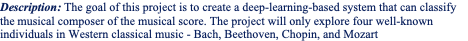
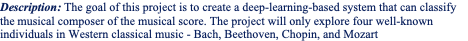
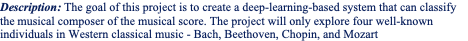
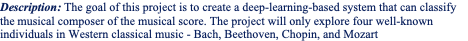

# Import libraries and packages as needed

In [2]:
!pip install pretty-midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 1.9 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=d79b9f53e465397e76030ce0e2e08b94fc83872c0452f904d6e8255fe0ce82f7
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi


In [157]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import zipfile
import copy
import pretty_midi
from IPython.display import FileLink
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import traceback

from google.colab import drive
from music21 import converter, note, chord, tempo, meter, key, instrument, articulations, dynamics
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from fractions import Fraction
from collections import defaultdict
from typing import List, Tuple
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers


warnings.filterwarnings("ignore")

# Data Collection

## Extract Dataset (Unzip it)

In [4]:
zip_path = '/kaggle/input/midi-classic-music/midiclassics.zip'
extract_path = '/kaggle/working/extracted_files'

In [5]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check folder structure
os.listdir(extract_path)

['Tarrega',
 'Hiller',
 'Tchaikovsky Lake Of The Swans Act 2 13mov.mid',
 'Kuhlau Sonatina op55 n3 1mov.mid',
 'Reger Burlesque op58 n3.mid',
 'Debussy Suite Bergamasque 3mov.mid',
 'Shostakovich',
 'Reinecke Piano Concerto n3 1mov.mid',
 'Tchaikovsky Lake Of The Swans Act 1 9mov.mid',
 'Poulenc',
 'Katzwarra',
 'Bizet Symphony in C 4mov.mid',
 'Buxethude Buxwv167 Canzonetta.mid',
 'Diabelli Sonatina op151 n1 1mov.mid',
 'Jensen',
 'Debussy Suite Bergamasque 2mov.mid',
 'Alkan',
 'Morel',
 'Skriabin',
 'Wagner Ride of the valkyries.mid',
 'Buxethude Buxwv160 Ciacona.mid',
 'Diabelli Sonatina op151 n4 1mov.mid',
 'Diabelli Sonatina op151 n3 2mov.mid',
 'Handel',
 'Kuhlau',
 'Clementi',
 'Scarlatti',
 'Pachebel Toccata n7.mid',
 "Rimsky Korsakov ''Flight Of the Bumblebee''.mid",
 'Liszt Paganini Etude n1.mid',
 'Rothchild Symphony Rmw12 1mov.mid',
 'Tchaikovsky Lake Of The Swans Act 1 3mov.mid',
 'Arensky',
 'Mendelssohn',
 'Fucick',
 'Tchaikovsky Lake Of The Swans Act 1 4mov.mid',
 'Rot

In [6]:
!ls -ld /kaggle/working/extracted_files/Bach
!ls -ld /kaggle/working/extracted_files/Beethoven
!ls -ld /kaggle/working/extracted_files/Chopin
!ls -ld /kaggle/working/extracted_files/Mozart

drwxr-xr-x 16 root root 12288 Aug  9 08:10 /kaggle/working/extracted_files/Bach
drwxr-xr-x 4 root root 12288 Aug  9 08:10 /kaggle/working/extracted_files/Beethoven
drwxr-xr-x 2 root root 12288 Aug  9 08:10 /kaggle/working/extracted_files/Chopin
drwxr-xr-x 6 root root 4096 Aug  9 08:10 /kaggle/working/extracted_files/Mozart


## Collect MID files for each top folder and subfolders

We are considering only `Bach`, `Beethoven`, `Chopin` and `Mozart` as mentioned in the project guidelines.

In [7]:
# Set the path where the MIDI files are stored
DATA_DIR = "/kaggle/working/extracted_files/"

# List of composers we want
TARGET_COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]

In [8]:
def collect_midi_files(data_dir, target_composers):
    midi_files_by_composer = defaultdict(list)

    for composer in target_composers:
        composer_dir = os.path.join(data_dir, composer)
        if not os.path.exists(composer_dir):
            print(f"[WARN] Directory not found for composer: {composer}")
            continue

        for root, _, files in os.walk(composer_dir):
            for file in files:
                if file.lower().endswith(('.mid', '.midi')):
                    full_path = os.path.join(root, file)
                    midi_files_by_composer[composer].append(full_path)

        print(f"[INFO] {composer}: {len(midi_files_by_composer[composer])} files collected")

    return midi_files_by_composer

In [9]:
# Run the function
midi_files_by_composer = collect_midi_files(DATA_DIR, TARGET_COMPOSERS)

[INFO] Bach: 1024 files collected
[INFO] Beethoven: 213 files collected
[INFO] Chopin: 136 files collected
[INFO] Mozart: 257 files collected


## Check if any other files are available in the folders apart from .mid or .midi

In [10]:
def list_unique_file_extensions(root_folder):
    extensions = set()

    for dirpath, _, files in os.walk(root_folder):
        for file in files:
            if '.' in file:
                ext = file.lower().rsplit('.', 1)[-1]
                extensions.add(ext)
            else:
                extensions.add('NO_EXTENSION')

    return extensions

In [11]:
# Example usage
for target_composer in TARGET_COMPOSERS:
    unique_exts = list_unique_file_extensions(f"{DATA_DIR}/{target_composer}")
    print(f"Unique file extensions found for {target_composer}:", unique_exts)

Unique file extensions found for Bach: {'NO_EXTENSION', 'mid'}
Unique file extensions found for Beethoven: {'zip', 'mid'}
Unique file extensions found for Chopin: {'mid'}
Unique file extensions found for Mozart: {'mid'}


# Data Pre-processing

## Perform Data Augmentation for the MIDI Files and Label each of them

In [11]:
def augment_single_file(filename, output_folder, num_augments):
    base_name = os.path.splitext(os.path.basename(filename))[0]

    try:
        midi = pretty_midi.PrettyMIDI(filename)
    except Exception as e:
        return f"Error reading {filename}: {e}"

    for i in range(num_augments):
        augmented = pretty_midi.PrettyMIDI()
        for instrument in midi.instruments:
            new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum)
            for note in instrument.notes:
                pitch_shift = random.choice([-2, -1, 0, 1, 2])
                new_pitch = min(max(note.pitch + pitch_shift, 0), 127)

                velocity_variation = random.randint(-10, 10)
                new_velocity = min(max(note.velocity + velocity_variation, 0), 127)

                time_scale = random.choice([0.9, 1.0, 1.1])
                start = note.start * time_scale
                end = note.end * time_scale

                new_note = pretty_midi.Note(
                    velocity=new_velocity,
                    pitch=new_pitch,
                    start=start,
                    end=end
                )
                new_instrument.notes.append(new_note)

            augmented.instruments.append(new_instrument)

        output_file = os.path.join(output_folder, f"{base_name}_aug{i}.mid")
        augmented.write(output_file)

    return None

In [12]:
def process_file(args):
    filename, output_folder, num_augments = args
    return augment_single_file(filename, output_folder, num_augments)

In [13]:
def augment_midi_folder_parallel(input_folder, output_folder, num_augments=5, batch_size=50, max_workers=None):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    midi_list = glob.glob(os.path.join(input_folder, '**', '*.mid'), recursive=True)
    midi_list += glob.glob(os.path.join(input_folder, '**', '*.midi'), recursive=True)

    total_files = len(midi_list)
    print(f"[INFO] Found {total_files} MIDI files.")

    if max_workers is None:
        max_workers = os.cpu_count() or 1

    for batch_start in range(0, total_files, batch_size):
        batch_files = midi_list[batch_start:batch_start + batch_size]

        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            results = list(tqdm(
                executor.map(process_file, [(f, output_folder, num_augments) for f in batch_files]),
                total=len(batch_files),
                desc=f"Processing batch {batch_start//batch_size + 1}"
            ))

        errors = [r for r in results if r is not None]
        for err in errors:
            print("[ERROR]", err)

In [14]:
augment_midi_folder_parallel(
    input_folder="/kaggle/working/extracted_files/Bach",
    output_folder="/kaggle/working/Bach_augmented",
    num_augments=3,
    batch_size=10,
    max_workers=os.cpu_count()
)

[INFO] Found 925 MIDI files.


Processing batch 93: 100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


In [15]:
augment_midi_folder_parallel(
    input_folder="/kaggle/working/extracted_files/Beethoven",
    output_folder="/kaggle/working/Beethoven_augmented",
    num_augments=3,
    batch_size=10,
    max_workers=os.cpu_count()
)

[INFO] Found 212 MIDI files.


Processing batch 10: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

[ERROR] Error reading /kaggle/working/extracted_files/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255



Processing batch 22: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


In [16]:
augment_midi_folder_parallel(
    input_folder="/kaggle/working/extracted_files/Mozart",
    output_folder="/kaggle/working/Mozart_augmented",
    num_augments=3,
    batch_size=10,
    max_workers=os.cpu_count()
)

[INFO] Found 257 MIDI files.


Processing batch 12: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

[ERROR] Error reading /kaggle/working/extracted_files/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2



Processing batch 26: 100%|██████████| 7/7 [00:00<00:00, 21.45it/s]


In [17]:
augment_midi_folder_parallel(
    input_folder="/kaggle/working/extracted_files/Chopin",
    output_folder="/kaggle/working/Chopin_augmented",
    num_augments=3,
    batch_size=10,
    max_workers=os.cpu_count()
)

[INFO] Found 136 MIDI files.


Processing batch 14: 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]


### Download augmented files

In [21]:
# Zip all the folders
!zip -r Bach_augmented.zip /kaggle/working/Bach_augmented

  adding: kaggle/working/Bach_augmented/ (stored 0%)
  adding: kaggle/working/Bach_augmented/065700b__aug2.mid (deflated 30%)
  adding: kaggle/working/Bach_augmented/009507b__aug2.mid (deflated 29%)
  adding: kaggle/working/Bach_augmented/2.Aus Liebe will mein Heiland sterban Soprano Aria_aug0.mid (deflated 25%)
  adding: kaggle/working/Bach_augmented/006906ba_aug2.mid (deflated 29%)
  adding: kaggle/working/Bach_augmented/Wtcii02b_aug1.mid (deflated 28%)
  adding: kaggle/working/Bach_augmented/Bwv019.7ch_aug1.mid (deflated 28%)
  adding: kaggle/working/Bach_augmented/Bwv1066 Orchestral Suite n1 1mov_aug1.mid (deflated 31%)
  adding: kaggle/working/Bach_augmented/Double Fugue n2_aug0.mid (deflated 30%)
  adding: kaggle/working/Bach_augmented/Piano version of Bachs two part inventions No.13_aug1.mid (deflated 30%)
  adding: kaggle/working/Bach_augmented/Bwv1041 Violin Concerto n1 2mov_aug1.mid (deflated 31%)
  adding: kaggle/working/Bach_augmented/025100b__aug2.mid (deflated 30%)
  addi

In [22]:
!zip -r Beethoven_augmented.zip /kaggle/working/Beethoven_augmented

  adding: kaggle/working/Beethoven_augmented/ (stored 0%)
  adding: kaggle/working/Beethoven_augmented/Piano Concerto n1 op15 3mov_aug0.mid (deflated 27%)
  adding: kaggle/working/Beethoven_augmented/Piano Concerto n5 op73 1mov ''Emperor''_aug1.mid (deflated 26%)
  adding: kaggle/working/Beethoven_augmented/Sonata No.14 Op 27 Sonata Quasi Una Fantasia_aug1.mid (deflated 25%)
  adding: kaggle/working/Beethoven_augmented/Sonatina Fa maj woo_aug0.mid (deflated 24%)
  adding: kaggle/working/Beethoven_augmented/Op.51_aug2.mid (deflated 29%)
  adding: kaggle/working/Beethoven_augmented/Sonatina WoO050_aug0.mid (deflated 23%)
  adding: kaggle/working/Beethoven_augmented/Bagatella op33 n4_aug1.mid (deflated 26%)
  adding: kaggle/working/Beethoven_augmented/Op.51_aug1.mid (deflated 28%)
  adding: kaggle/working/Beethoven_augmented/Piano Sonata n08 op13 3mov ''Pathetique''_aug2.mid (deflated 23%)
  adding: kaggle/working/Beethoven_augmented/Andante in F Major_aug1.mid (deflated 27%)
  adding: ka

In [23]:
!zip -r Chopin_augmented.zip /kaggle/working/Chopin_augmented

  adding: kaggle/working/Chopin_augmented/ (stored 0%)
  adding: kaggle/working/Chopin_augmented/Prelude n09 op28 ''Vision''_aug0.mid (deflated 25%)
  adding: kaggle/working/Chopin_augmented/Etude op25 n01 ''Harp Etude''_aug2.mid (deflated 25%)
  adding: kaggle/working/Chopin_augmented/Ecossaise No.2 in G_aug2.mid (deflated 21%)
  adding: kaggle/working/Chopin_augmented/Fantasie Impromptu op66_aug0.mid (deflated 25%)
  adding: kaggle/working/Chopin_augmented/Prelude n22 op28 ''Impatience''_aug2.mid (deflated 26%)
  adding: kaggle/working/Chopin_augmented/Prelude n17 op28 ''Scene On the Place of Notre Dame_aug2.mid (deflated 32%)
  adding: kaggle/working/Chopin_augmented/Sonata op35 n4 _aug2.mid (deflated 26%)
  adding: kaggle/working/Chopin_augmented/Ballad op53_aug0.mid (deflated 27%)
  adding: kaggle/working/Chopin_augmented/Etude op10 n03_aug1.mid (deflated 22%)
  adding: kaggle/working/Chopin_augmented/Nocturne op09 n2_aug2.mid (deflated 24%)
  adding: kaggle/working/Chopin_augment

In [24]:
!zip -r Mozart_augmented.zip /kaggle/working/Mozart_augmented

  adding: kaggle/working/Mozart_augmented/ (stored 0%)
  adding: kaggle/working/Mozart_augmented/Tchaikovsky Lake Of The Swans Act 1 9mov_aug1.mid (deflated 26%)
  adding: kaggle/working/Mozart_augmented/K280 Piano sonata n02 2mov_aug2.mid (deflated 31%)
  adding: kaggle/working/Mozart_augmented/K521 Piano Sonata 4 Hands_aug0.mid (deflated 23%)
  adding: kaggle/working/Mozart_augmented/Liszt Paganini Etude n3_aug1.mid (deflated 24%)
  adding: kaggle/working/Mozart_augmented/Lizt Piano Concerto n1 S124_aug2.mid (deflated 25%)
  adding: kaggle/working/Mozart_augmented/Dvorak Slavonic dance n8_aug0.mid (deflated 25%)
  adding: kaggle/working/Mozart_augmented/K626 Requiem 04 Dies Irae_aug1.mid (deflated 21%)
  adding: kaggle/working/Mozart_augmented/Piano Concerto n8 K246 1mov_aug2.mid (deflated 25%)
  adding: kaggle/working/Mozart_augmented/K626 Requiem 08 offertorio domine jesu_aug1.mid (deflated 29%)
  adding: kaggle/working/Mozart_augmented/Tchaikovsky Lake Of The Swans Act 2 13mov_aug

In [26]:
!ls -lrt

total 73608
drwxr-xr-x 140 root root    12288 Aug  9 06:20 extracted_files
drwxr-xr-x   2 root root   143360 Aug  9 06:53 Bach_augmented
drwxr-xr-x   2 root root    45056 Aug  9 06:57 Beethoven_augmented
drwxr-xr-x   2 root root    65536 Aug  9 06:59 Mozart_augmented
drwxr-xr-x   2 root root    36864 Aug  9 07:00 Chopin_augmented
-rw-r--r--   1 root root 23358045 Aug  9 07:17 Bach_augmented.zip
-rw-r--r--   1 root root 23072842 Aug  9 07:17 Beethoven_augmented.zip
-rw-r--r--   1 root root  4650875 Aug  9 07:17 Chopin_augmented.zip
-rw-r--r--   1 root root 23980790 Aug  9 07:17 Mozart_augmented.zip


In [28]:
# Download the zipped files now
FileLink(r'Bach_augmented.zip')

/kaggle/working/Bach_augmented.zip

In [29]:
FileLink(r'Beethoven_augmented.zip')

/kaggle/working/Beethoven_augmented.zip

In [30]:
FileLink(r'Chopin_augmented.zip')

/kaggle/working/Chopin_augmented.zip

In [31]:
FileLink(r'Mozart_augmented.zip')

/kaggle/working/Mozart_augmented.zip

## Plot visualizations of MIDI File Statistics

In [13]:
# Ensure Seaborn style
sns.set(style="whitegrid")

# Function to extract MIDI stats
def extract_midi_stats(midi_files_by_composer):
    stats = []
    for composer, file_list in midi_files_by_composer.items():
        for file_path in file_list:
            try:
                pm = pretty_midi.PrettyMIDI(file_path)
                duration = pm.get_end_time()
                note_count = sum(len(inst.notes) for inst in pm.instruments)
                pitch_values = [note.pitch for inst in pm.instruments for note in inst.notes]
                tempo_estimates = pm.get_tempo_changes()[1] if len(pm.get_tempo_changes()[1]) > 0 else [0]
                instruments_used = [inst.program for inst in pm.instruments if not inst.is_drum]

                stats.append({
                    "composer": composer,
                    "file": os.path.basename(file_path),
                    "duration_sec": duration,
                    "note_count": note_count,
                    "pitch_values": pitch_values,
                    "avg_pitch": np.mean(pitch_values) if pitch_values else 0,
                    "avg_tempo": np.mean(tempo_estimates),
                    "instrument_programs": instruments_used
                })
            except Exception as e:
                print(f"[WARN] Could not process {file_path}: {e}")
    return pd.DataFrame(stats)

In [14]:
# Extract stats
midi_stats_df = extract_midi_stats(midi_files_by_composer)

[WARN] Could not process /kaggle/working/extracted_files/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
[WARN] Could not process /kaggle/working/extracted_files/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2


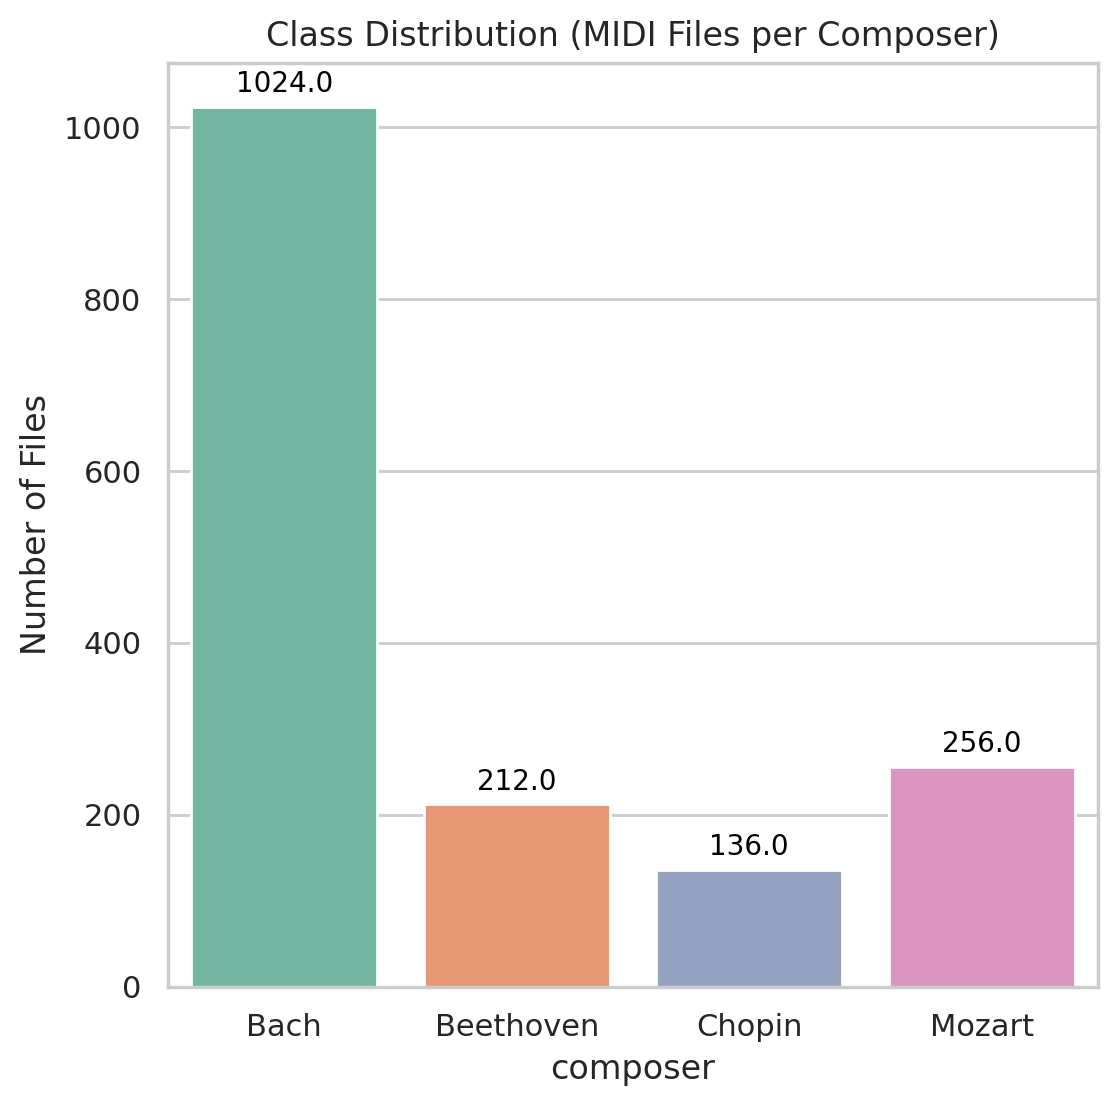

In [23]:
# Class Distribution with counts on bars
plt.figure(figsize=(6,6))
ax = sns.countplot(x="composer", data=midi_stats_df, palette="Set2")
plt.title("Class Distribution (MIDI Files per Composer)")
plt.ylabel("Number of Files")

# Add count labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=10, color='black', 
                xytext=(0, 3), textcoords='offset points')

plt.show()

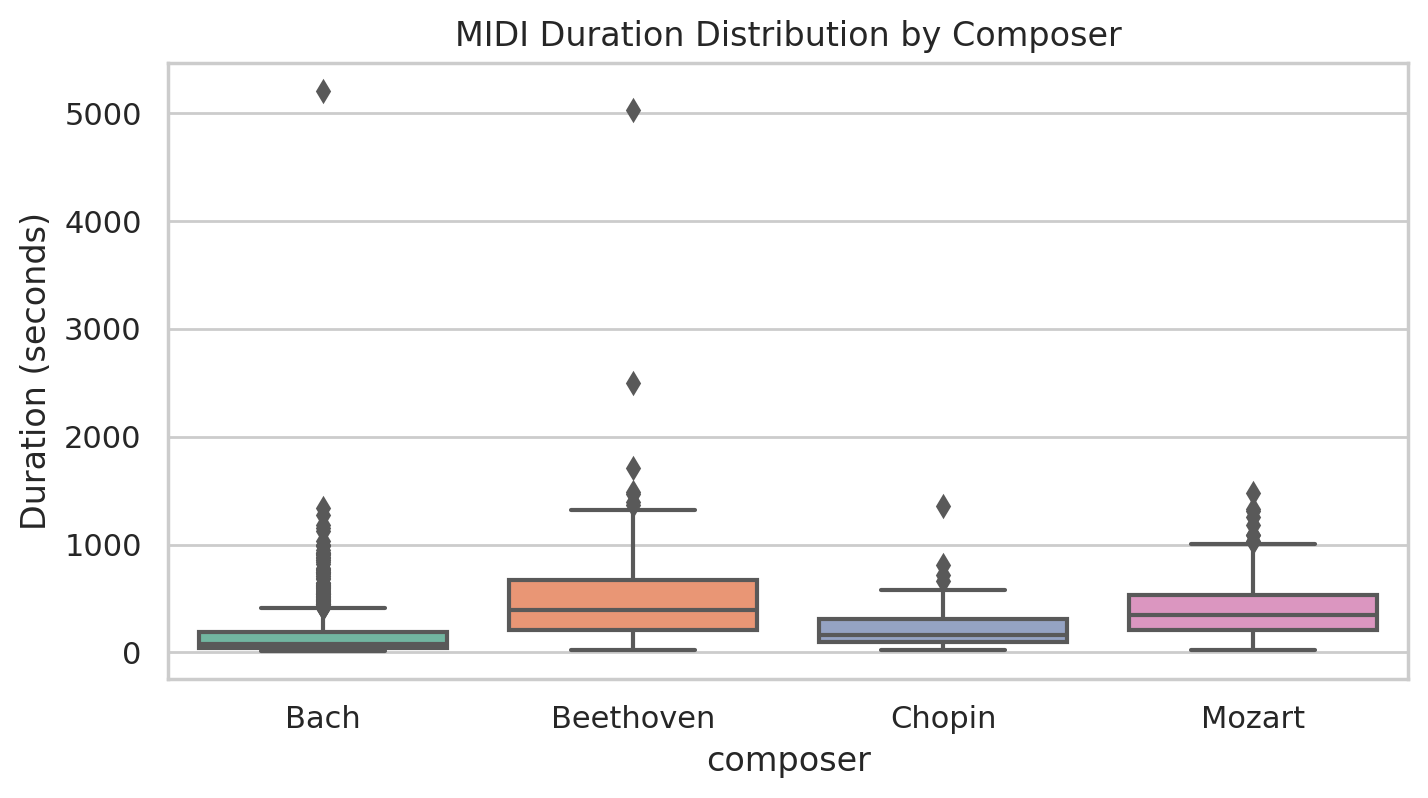

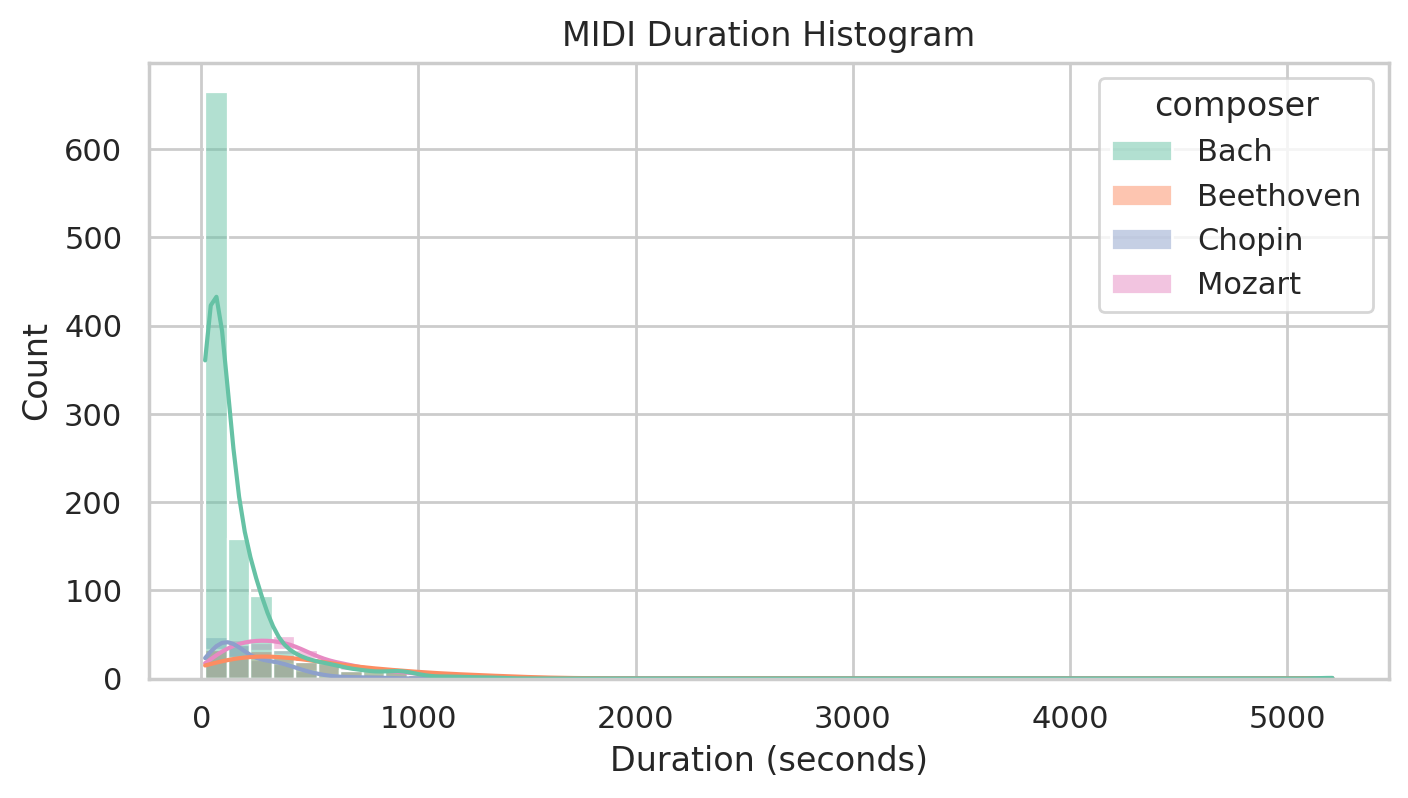

In [16]:
# Duration Distribution
plt.figure(figsize=(8,4))
sns.boxplot(x="composer", y="duration_sec", data=midi_stats_df, palette="Set2")
plt.title("MIDI Duration Distribution by Composer")
plt.ylabel("Duration (seconds)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(data=midi_stats_df, x="duration_sec", hue="composer", kde=True, bins=50, palette="Set2")
plt.title("MIDI Duration Histogram")
plt.xlabel("Duration (seconds)")
plt.show()

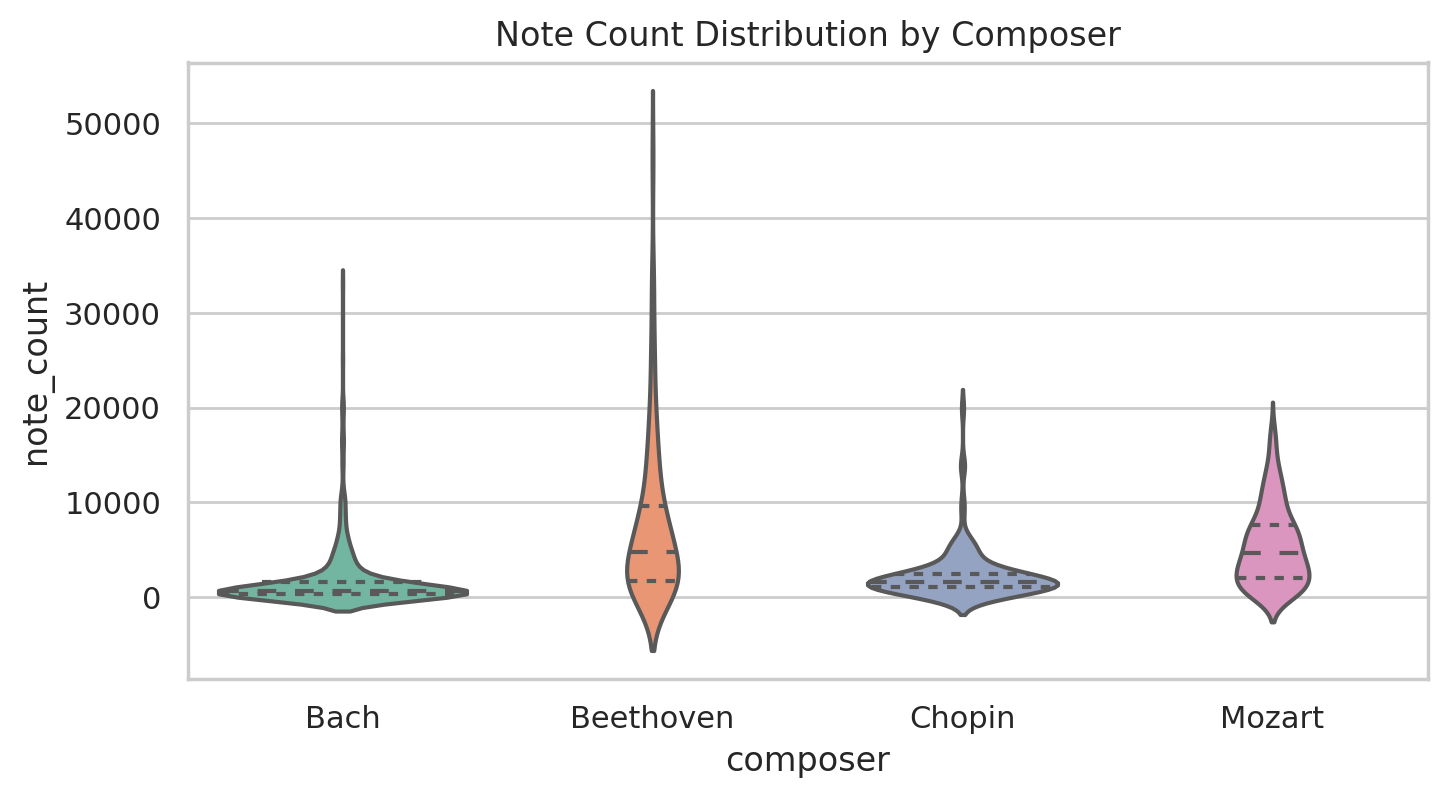

In [17]:
# Note Count Distribution
plt.figure(figsize=(8,4))
sns.violinplot(x="composer", y="note_count", data=midi_stats_df, palette="Set2", inner="quart")
plt.title("Note Count Distribution by Composer")
plt.show()

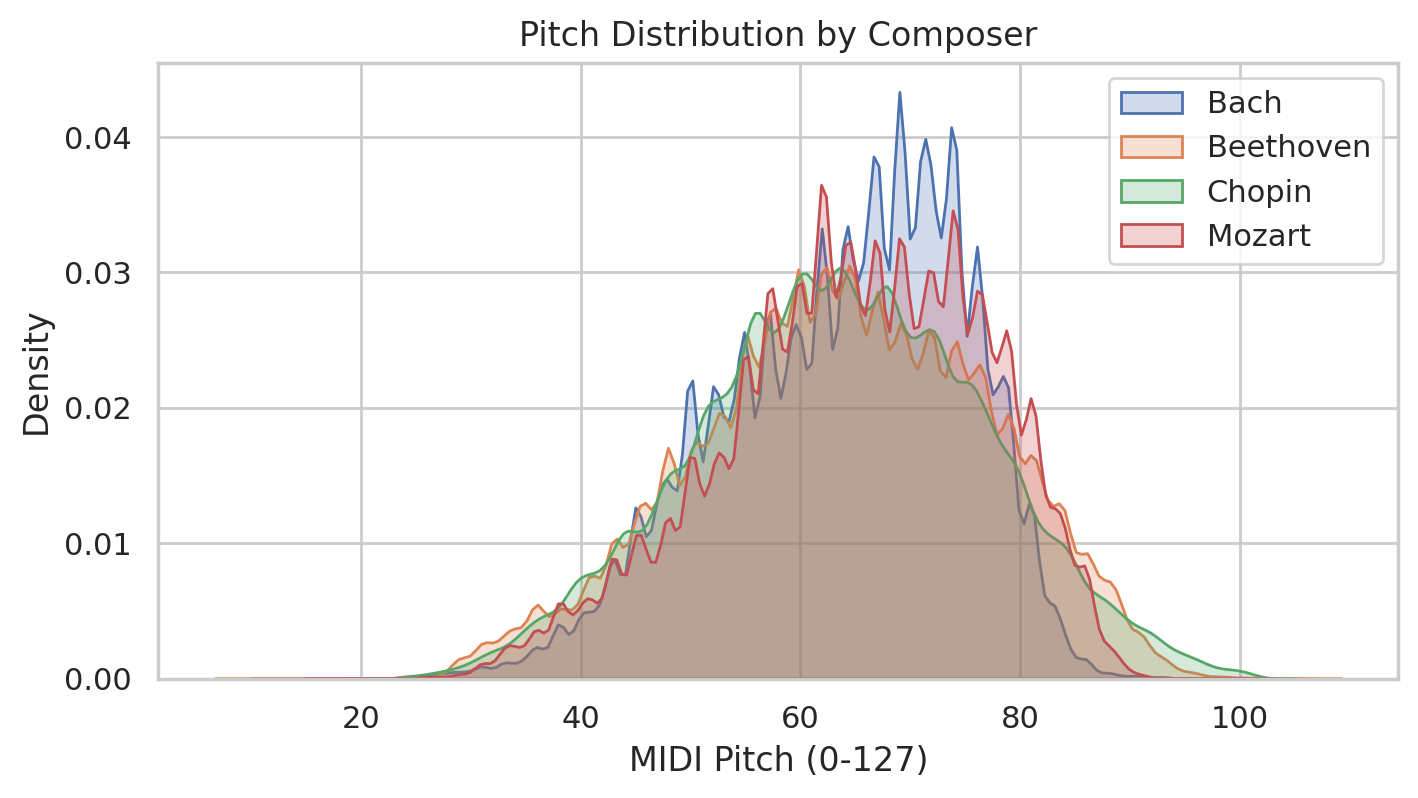

In [18]:
# Pitch Distribution
plt.figure(figsize=(8,4))
for composer in midi_stats_df["composer"].unique():
    all_pitches = [p for pitches in midi_stats_df[midi_stats_df["composer"] == composer]["pitch_values"] for p in pitches]
    sns.kdeplot(all_pitches, label=composer, fill=True)
plt.title("Pitch Distribution by Composer")
plt.xlabel("MIDI Pitch (0-127)")
plt.ylabel("Density")
plt.legend()
plt.show()

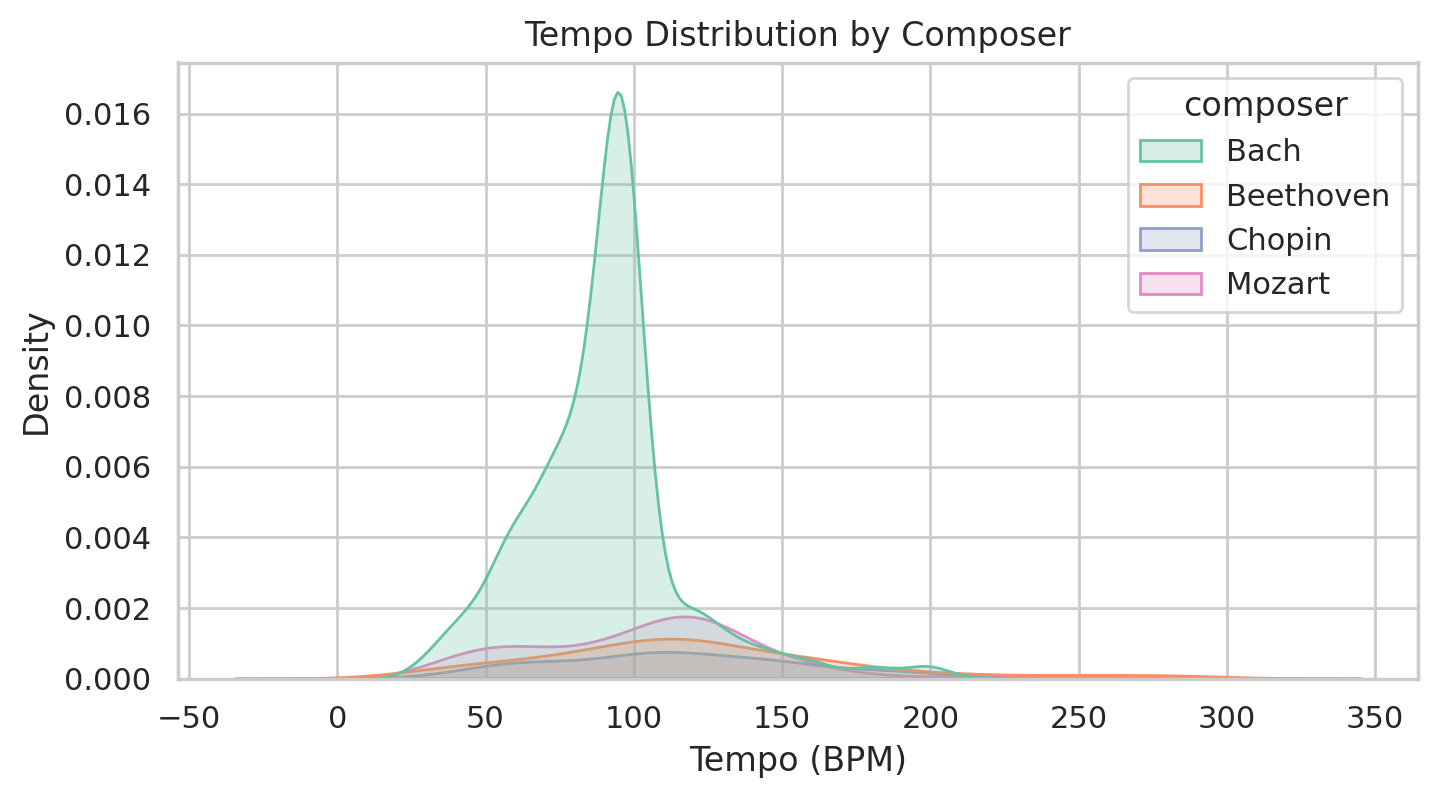

In [19]:
# Tempo Distribution
plt.figure(figsize=(8,4))
sns.kdeplot(data=midi_stats_df, x="avg_tempo", hue="composer", fill=True, palette="Set2")
plt.title("Tempo Distribution by Composer")
plt.xlabel("Tempo (BPM)")
plt.show()

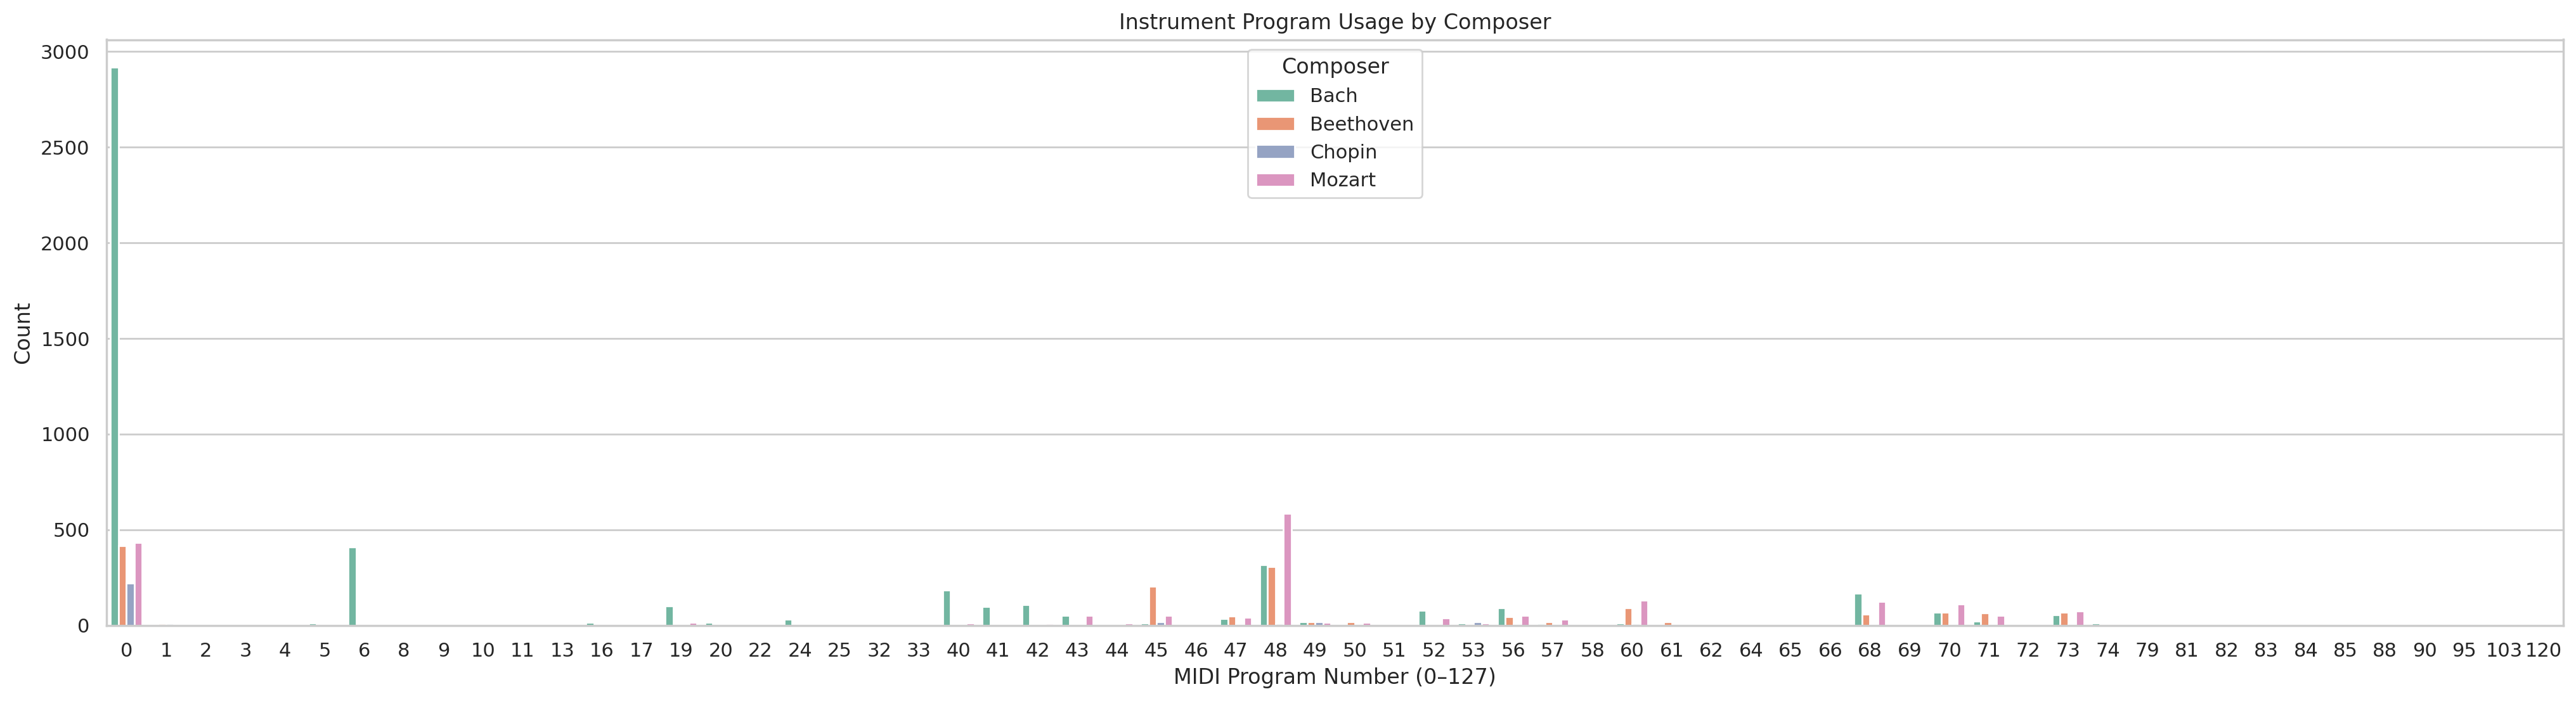

In [21]:
# Instrument Usage
instrument_counts = []
for _, row in midi_stats_df.iterrows():
    for prog in row["instrument_programs"]:
        instrument_counts.append({"composer": row["composer"], "program": prog})

instrument_df = pd.DataFrame(instrument_counts)
instrument_summary = instrument_df.groupby(["composer", "program"]).size().reset_index(name="count")

plt.figure(figsize=(25,6))
sns.barplot(x="program", y="count", hue="composer", data=instrument_summary, palette="Set2")
plt.title("Instrument Program Usage by Composer")
plt.xlabel("MIDI Program Number (0–127)")
plt.ylabel("Count")
plt.legend(title="Composer")
plt.show()

### Sample Piano Roll (timeline of notes)

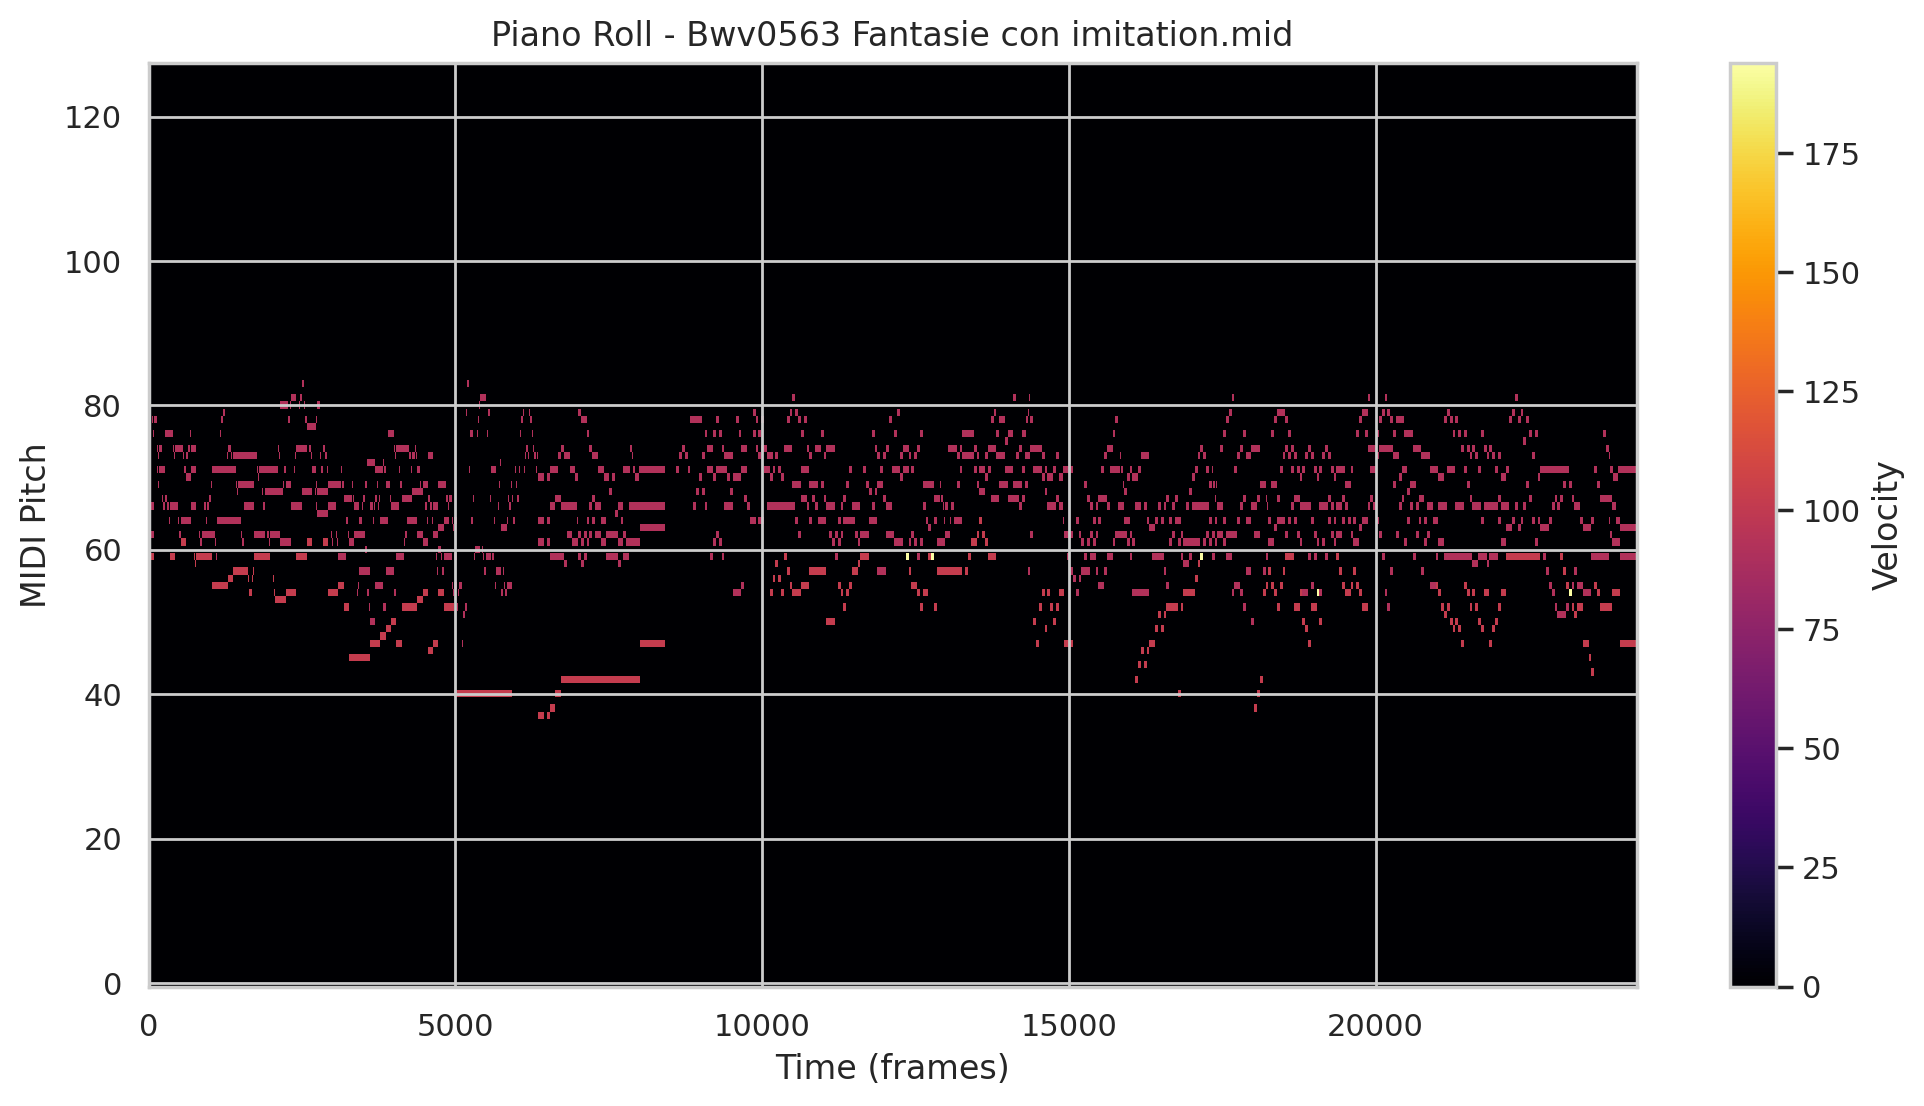

In [26]:
def plot_piano_roll(midi_path):
    pm = pretty_midi.PrettyMIDI(midi_path)
    roll = pm.get_piano_roll(fs=100)  # fs = frames per second

    plt.figure(figsize=(12, 6))
    plt.imshow(roll, aspect='auto', origin='lower', 
               cmap='inferno', interpolation='nearest')
    plt.xlabel('Time (frames)')
    plt.ylabel('MIDI Pitch')
    plt.title(f"Piano Roll - {os.path.basename(midi_path)}")
    plt.colorbar(label='Velocity')
    plt.show()

plot_piano_roll(midi_files_by_composer["Bach"][0])

### Sample MIDI Event Listing — textual representation

In [27]:
def print_midi_notes(midi_path):
    pm = pretty_midi.PrettyMIDI(midi_path)
    for instrument in pm.instruments:
        print(f"Instrument: {pretty_midi.program_to_instrument_name(instrument.program)}")
        for note in instrument.notes:
            print(f"Pitch: {note.pitch}, Start: {note.start:.2f}, End: {note.end:.2f}, Velocity: {note.velocity}")

# Example
print_midi_notes(midi_files_by_composer["Bach"][0])

Instrument: Church Organ
Pitch: 78, Start: 0.43, End: 0.64, Velocity: 92
Pitch: 76, Start: 0.64, End: 0.86, Velocity: 92
Pitch: 66, Start: 0.00, End: 0.86, Velocity: 92
Pitch: 78, Start: 0.86, End: 1.29, Velocity: 92
Pitch: 74, Start: 1.29, End: 1.50, Velocity: 92
Pitch: 73, Start: 1.50, End: 1.71, Velocity: 92
Pitch: 74, Start: 1.71, End: 2.14, Velocity: 92
Pitch: 71, Start: 2.14, End: 2.57, Velocity: 92
Pitch: 76, Start: 2.57, End: 3.86, Velocity: 92
Pitch: 74, Start: 3.86, End: 4.07, Velocity: 92
Pitch: 73, Start: 4.07, End: 4.29, Velocity: 92
Pitch: 74, Start: 4.29, End: 5.57, Velocity: 92
Pitch: 73, Start: 5.57, End: 5.79, Velocity: 92
Pitch: 71, Start: 5.79, End: 6.00, Velocity: 92
Pitch: 73, Start: 6.00, End: 6.43, Velocity: 92
Pitch: 74, Start: 6.43, End: 6.64, Velocity: 92
Pitch: 76, Start: 6.64, End: 6.86, Velocity: 92
Pitch: 70, Start: 6.00, End: 6.86, Velocity: 92
Pitch: 74, Start: 6.86, End: 7.71, Velocity: 92
Pitch: 71, Start: 6.86, End: 7.71, Velocity: 92
Pitch: 66, Star

### Piano roll plot


🎼 Bach - Sample Piano Roll: Bwv1069 Orchestral suite n4 Menuet.mid


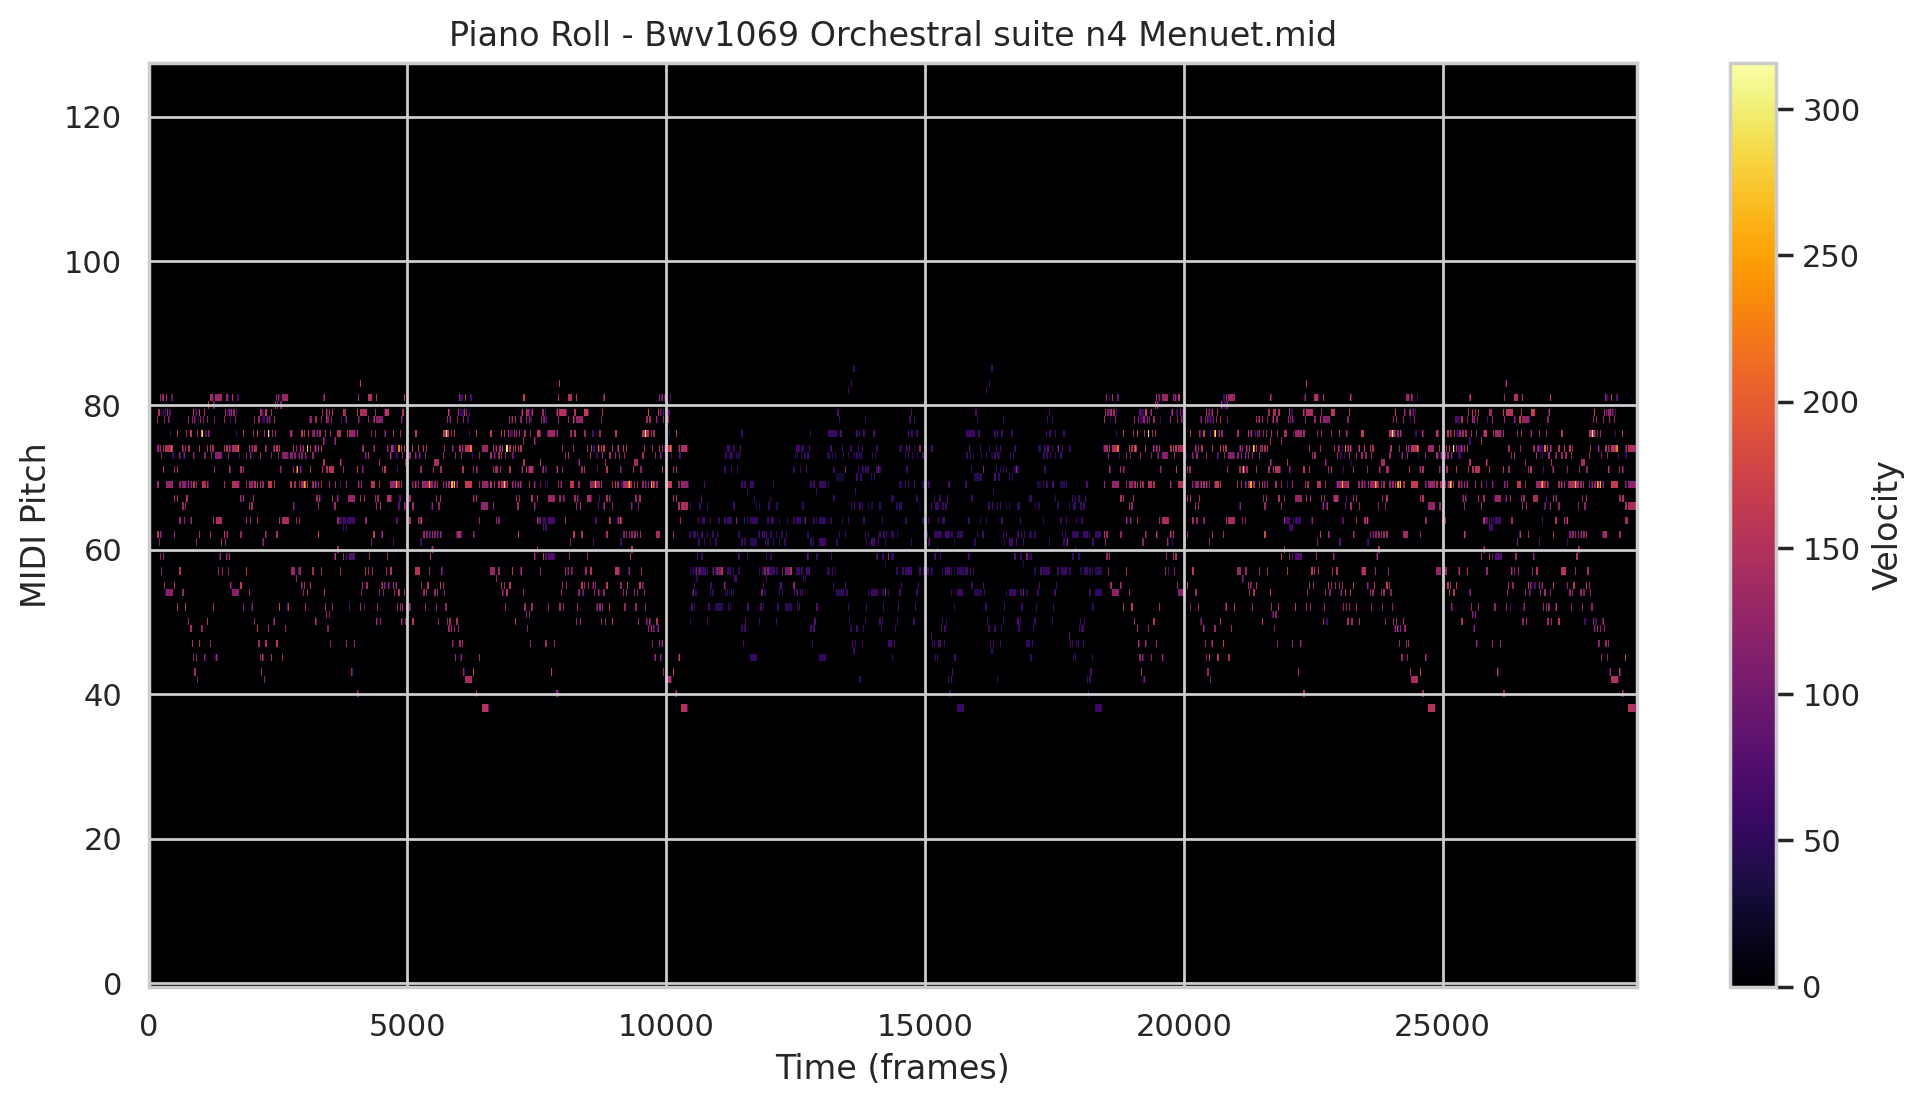


🎼 Beethoven - Sample Piano Roll: Lieder op48 n4 ''Die Ehre Gottes Aus Der Natur''.mid


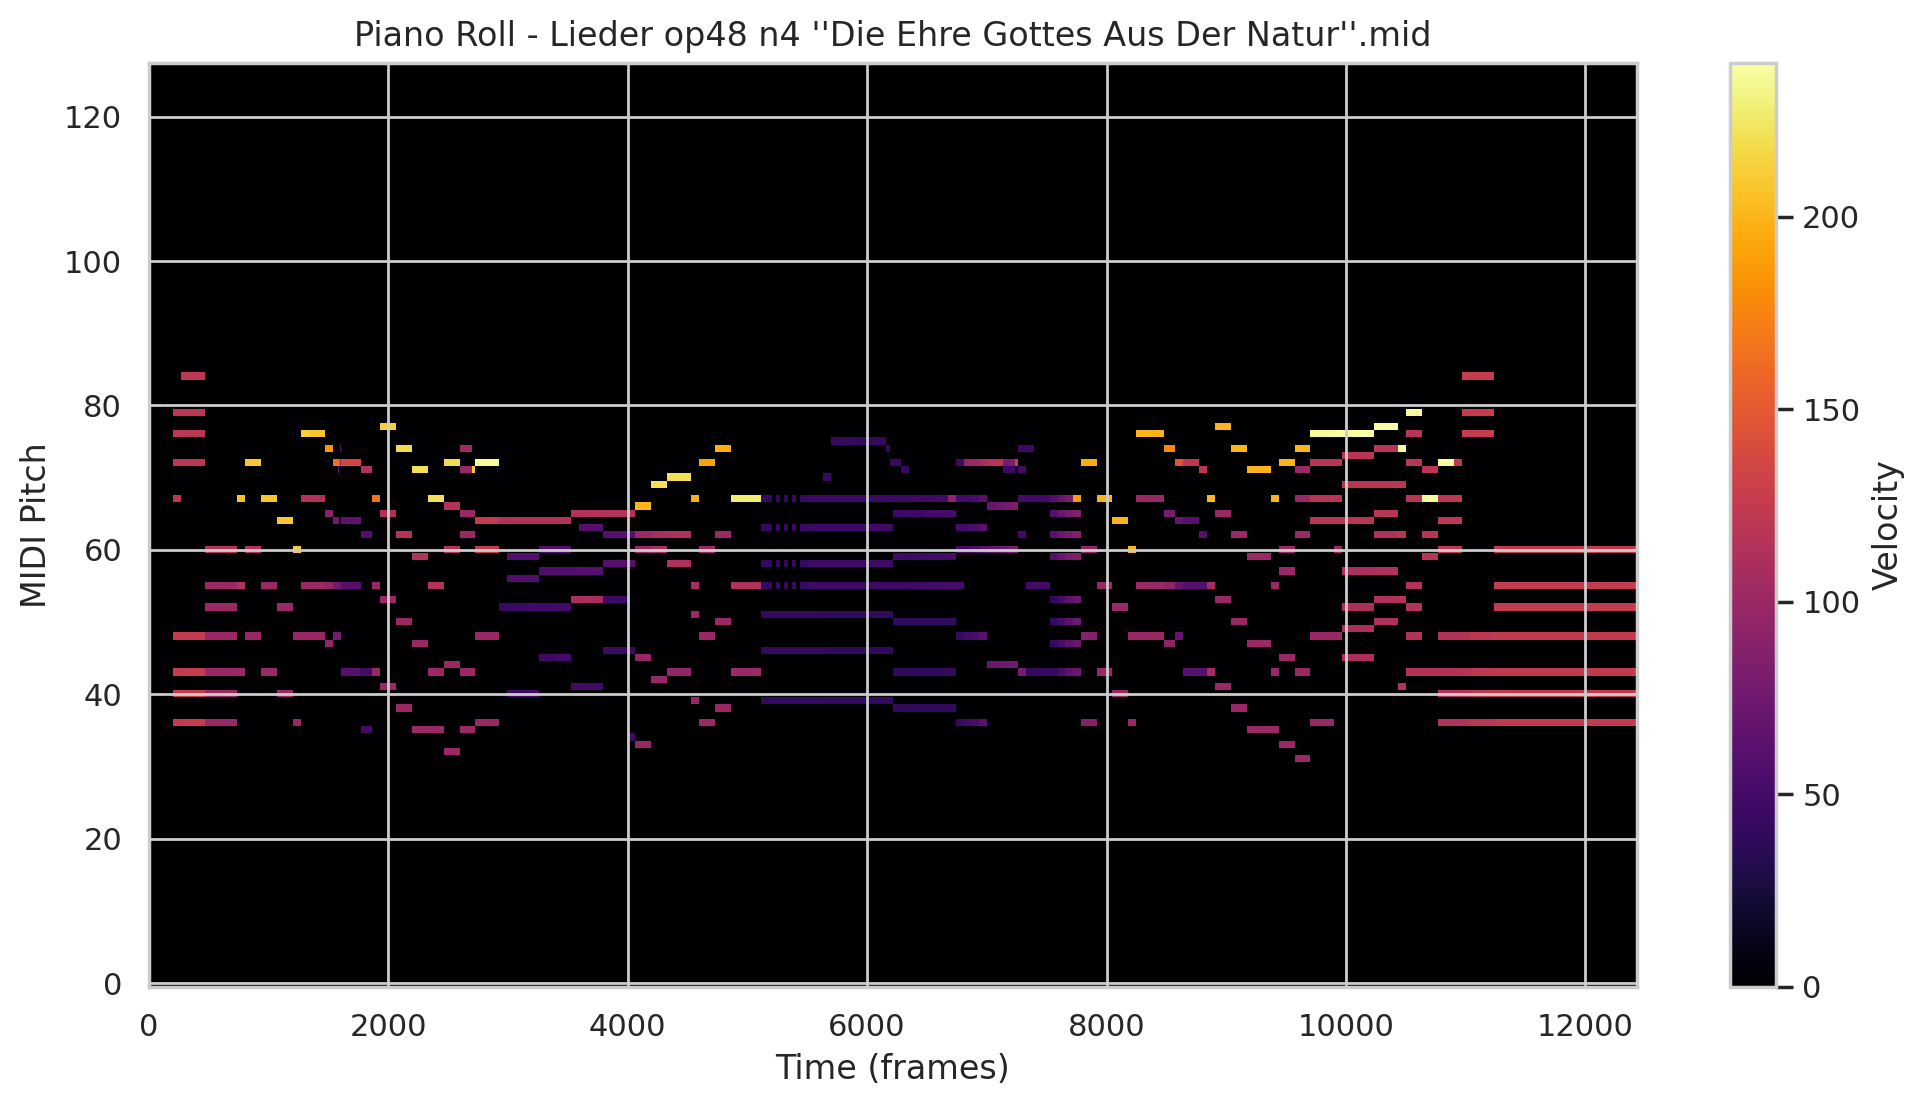


🎼 Chopin - Sample Piano Roll: Mazurka op67 n3 Drchew.mid


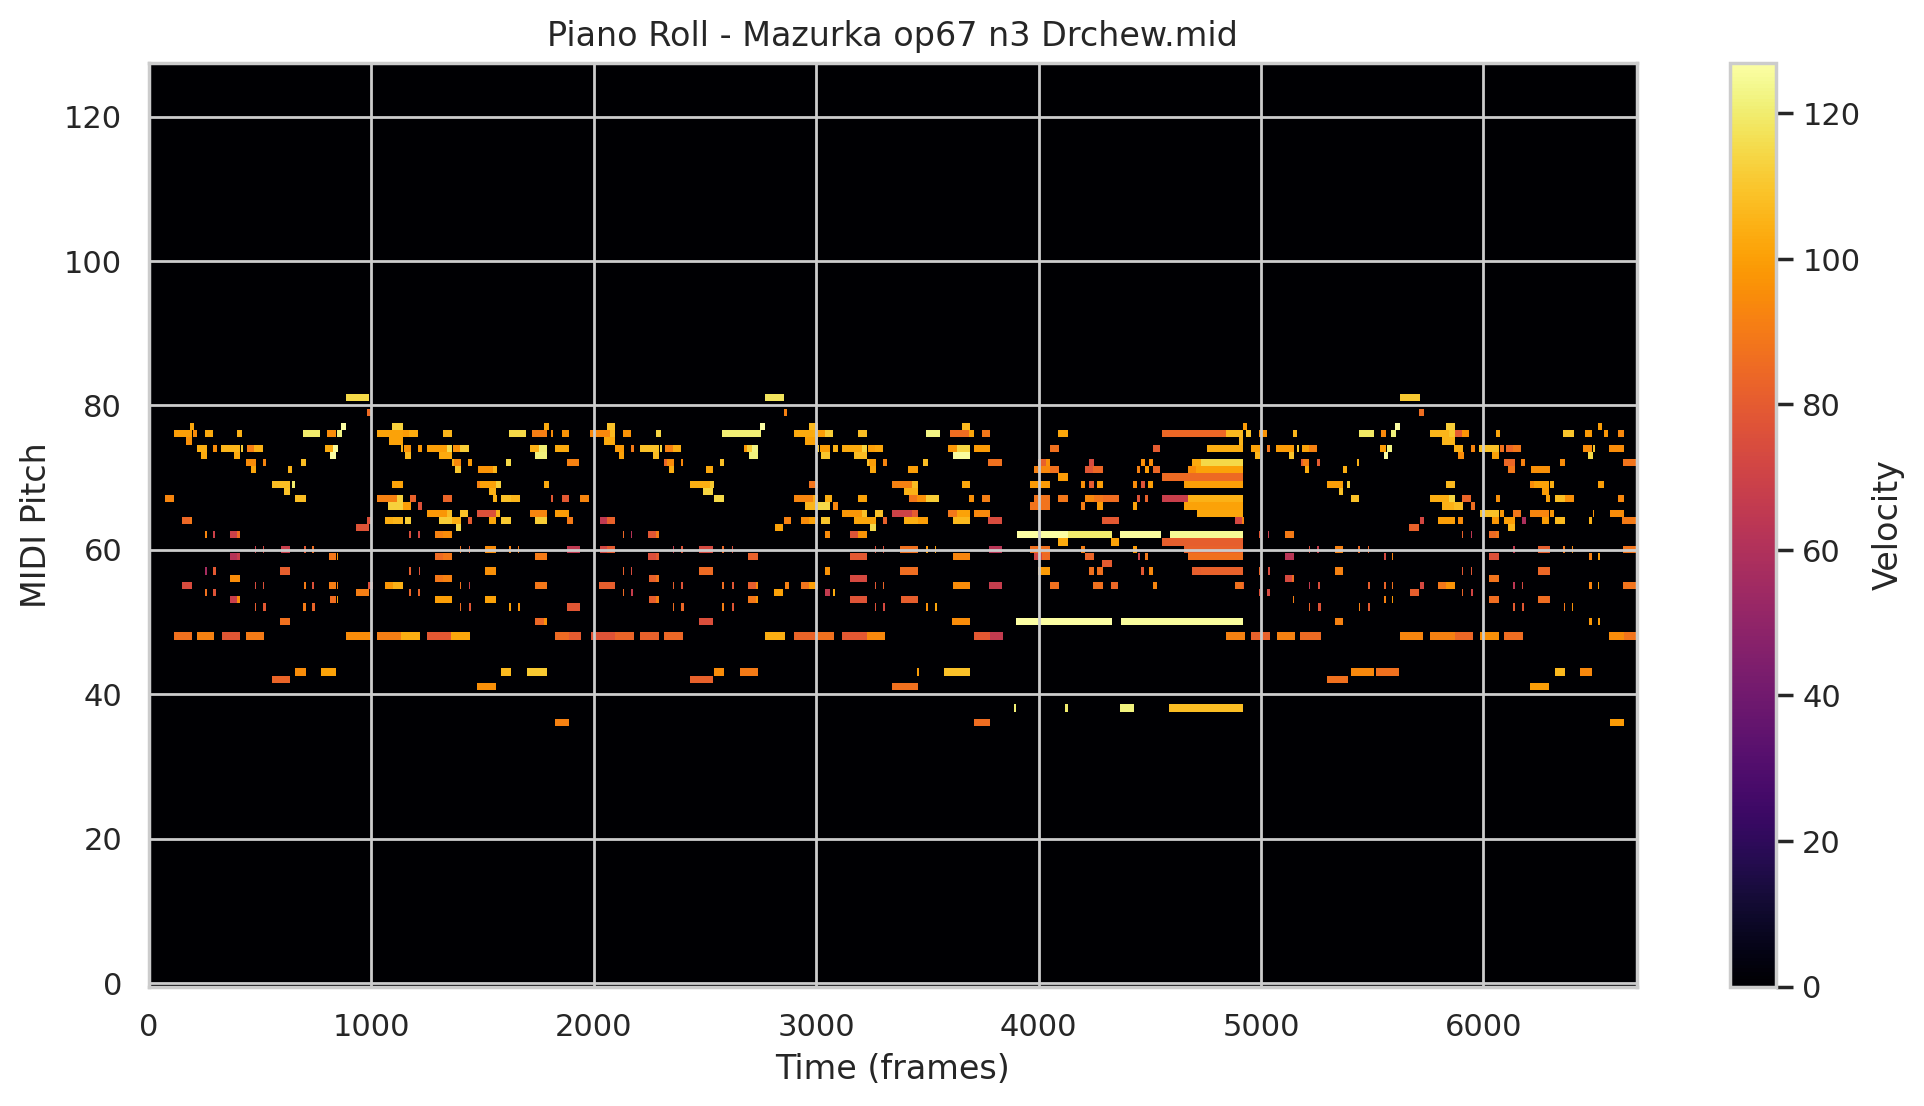


🎼 Mozart - Sample Piano Roll: Symphony n36 K425 1mov ''Linz''.mid


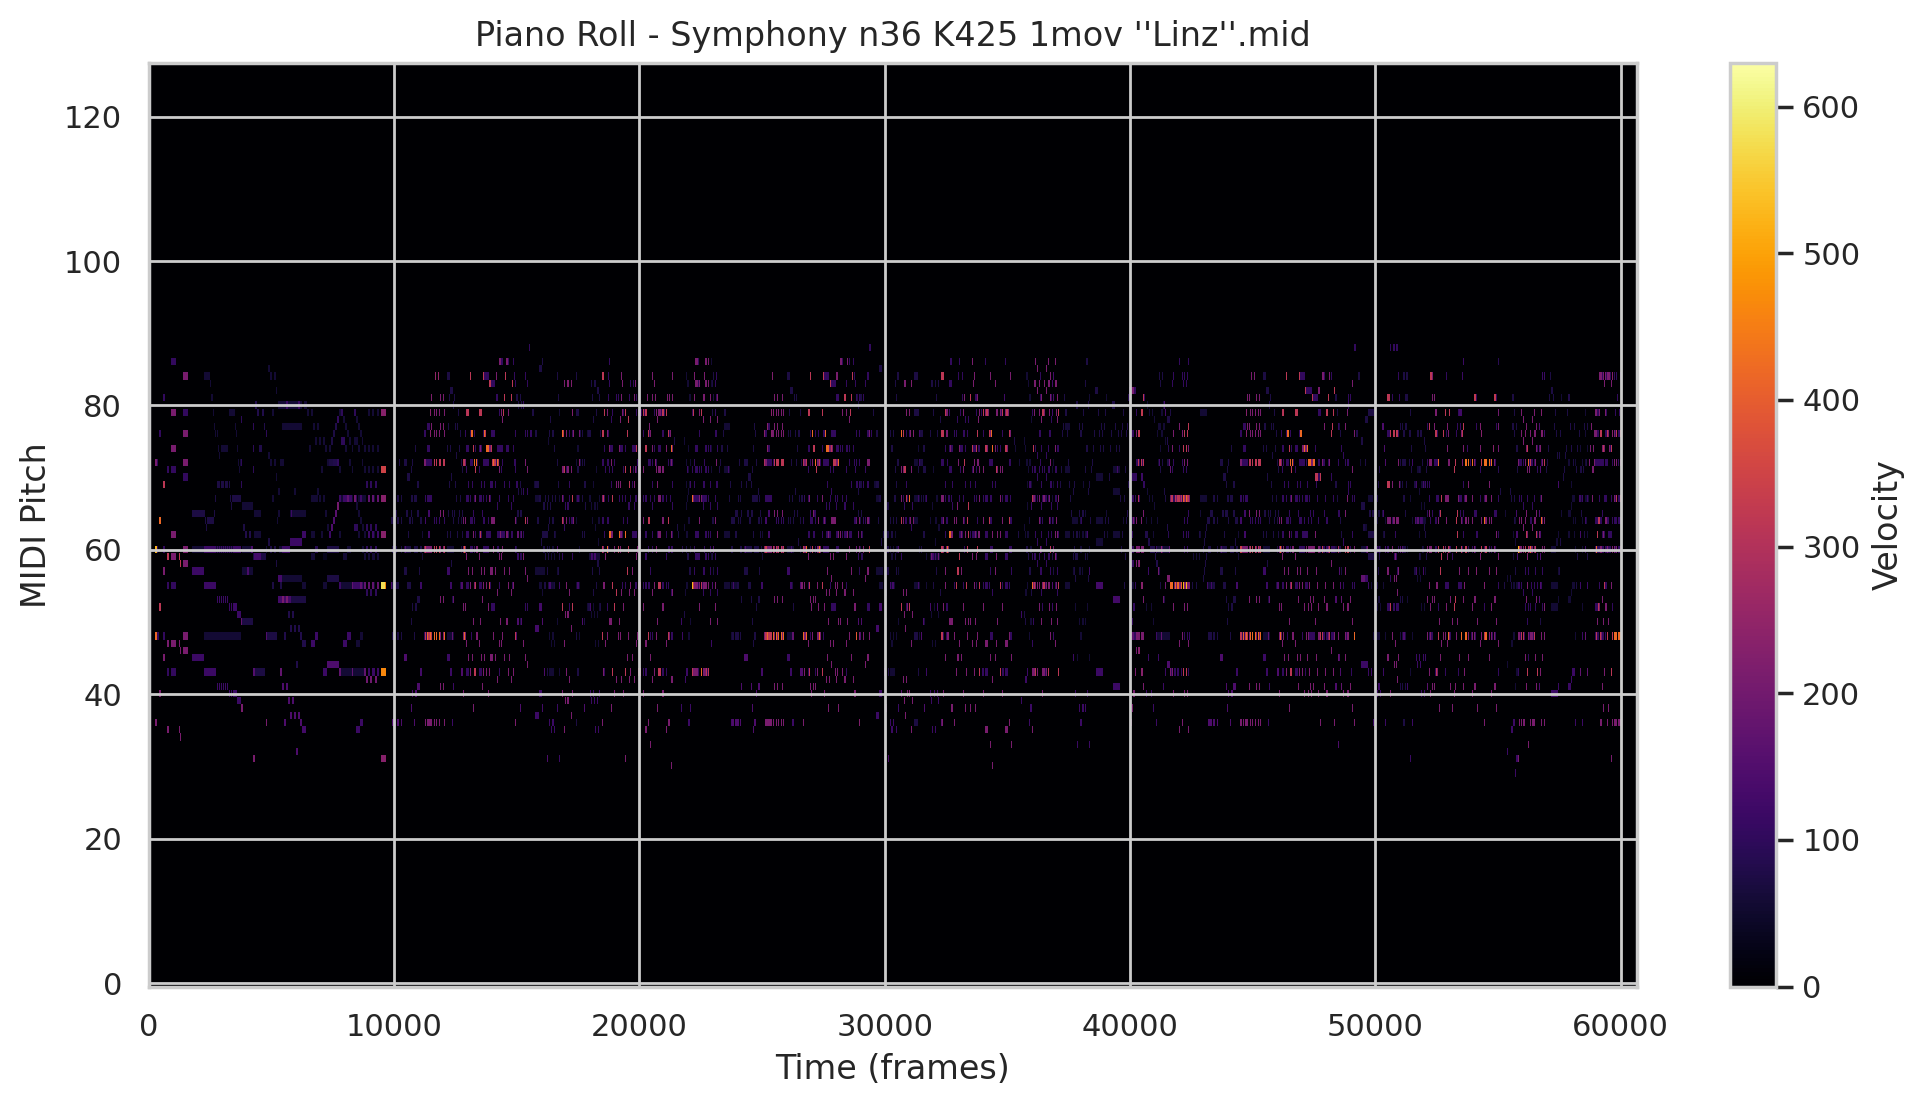

In [28]:
def plot_piano_roll(midi_path):
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        roll = pm.get_piano_roll(fs=100)  # 100 frames per second

        plt.figure(figsize=(12, 6))
        plt.imshow(roll, aspect='auto', origin='lower', 
                   cmap='inferno', interpolation='nearest')
        plt.xlabel('Time (frames)')
        plt.ylabel('MIDI Pitch')
        plt.title(f"Piano Roll - {os.path.basename(midi_path)}")
        plt.colorbar(label='Velocity')
        plt.show()
    except Exception as e:
        print(f"[WARN] Could not plot piano roll for {midi_path}: {e}")

# --- Integration into EDA ---
for composer in midi_files_by_composer.keys():
    if midi_files_by_composer[composer]:
        sample_file = random.choice(midi_files_by_composer[composer])
        print(f"\n🎼 {composer} - Sample Piano Roll: {os.path.basename(sample_file)}")
        plot_piano_roll(sample_file)

# Feature Extraction

## MIDI Feature Extraction Notes

I used `music21` for parsing and feature extraction. It's designed for symbolic music analysis pipelines but it can be a bit slower when working with larger collections - using their parallel processing is a great option.

---

### Performance Notes
- **Parallelism**: Enabled using `concurrent.futures` to help speed up the multi-file extraction.
- **CPU Use**: dependening on the amount of usable RAM try adjusting `max_workers` i.e. `min(6, os.cpu_count()-1)` to balance speed with memory.
- **Large Files**: Even with orchestral MIDIs or pieces that have higher resolution can take a few extra seconds per files when using music21 for parsing.

---

### Extracted Features Overview

| Feature | Description | Why It Matters for Classification |
|---------|-------------|------------------------------------|
| `notes` | List of note pitches (encoded as MIDI numbers). | Core melodic content, as composer styles often diverge in their pitch usage. |
| `chords` | List of chord symbols (root + quality). | Harmonic vocabulary - composers tend to favor certain chord progressions. |
| `tempo` | Average beats-per-minute derived from MIDI tempo events. | Represents pacing - for example, Romantic composers vs Classical composers often tend towards different average tempos. |
| `time_signatures` | Detected time signature(s)(e.g., 4/4, 3/4). | Temporal structure - different repetitions; e.g., Waltz (3/4) vs March (2/4). |
| `rhythm_iois` | Inter-onset intervals between the consecutive notes. | Represents the variation and complexity of rhythms. |
| `key_signatures` | Tonal key(s) detected (e.g., C major, A minor). | Tonal center - tonal preferences often define composers. |
| `instruments` | Instruments used in the piece (if paid attention to and encoded). | Orchestration styles; even for piano works, encoding can still be useful. |
| `articulations` | Aggregated articulation markings (staccato, legato, accent, etc.). | Expressive detail - composers differ in articulation density. |
| `dynamics` | Relative loudness/volume markings (p, mf, f, etc.). | Expressive quality dynamics - may function as a stylistic fingerprint in scores by a composer. |
| `polyphony_series` | Count of notes per time step. | The most useful number, effectively counts texture density at a point in time; polyphonic writing is far more complex. |
| `polyphony_avg` | Average simultaneous notes. | Capture standard texture. |
| `polyphony_max` | Maximum simultaneous notes. | Capture dense climaxes. |

---

### Quantization
- **Polyphony** is calculated after the notes are quantized to a grid (`quantize_step_q` = 0.25 quarter notes by default).
- A smaller grid increases polyphony resolution (but increases computation time).

---

### Limits
- **Articulations/Dynamics**: Only extracted if present explicitly in the MIDI or score; most MIDI files do not include these.
- **Instrument Metadata**: May not be available — can be `None` for some files.
- **Tempo Changes**: Only the average tempo is reported; in order of expressive timing, a tempo curve must be evaluated.

---

### Next Steps After Extraction
1. **Look over results** — ensure that the all features were extracted correctly (`NaN` handling).
2. **Save** the extracted dataframe as `.pkl` or `.parquet`.
3. **Feature engineering** — explicate symbolic features into numeric vectors (piano roll, chroma, event sequences, statistical summaries).
4. **Model Training** — use the features processed for the classification model.

In [30]:
def extract_features_from_midi(midi_path, quantize_step_q=0.25):
    """
    Extract features from a single MIDI file using music21.
    quantize_step_q: quantization step in quarter lengths used to compute polyphony stats.
    Returns dict with 'ok' boolean and either 'result' or 'error'.
    """
    try:
        score = converter.parse(midi_path)

        # -- Notes --
        note_list = []
        for n in score.recurse().notes:
            if isinstance(n, note.Note):
                vol = None
                # music21 may store velocity under volume.velocity
                try:
                    vol = int(n.volume.velocity) if n.volume and n.volume.velocity is not None else None
                except Exception:
                    vol = None
                note_list.append({
                    "offset_q": float(n.offset),
                    "pitch": int(n.pitch.midi),
                    "duration_q": float(n.quarterLength),
                    "velocity": vol,
                    "articulations": [type(a).__name__ for a in getattr(n, "articulations", [])],
                    "expressions": [type(e).__name__ for e in getattr(n, "expressions", [])]
                })

        # -- Chords --
        chord_list = []
        for c in score.recurse().getElementsByClass(chord.Chord):
            chord_list.append({
                "offset_q": float(c.offset),
                "pitches": [int(p.midi) for p in c.pitches],
                "duration_q": float(c.quarterLength)
            })

        # -- Tempo --
        tempo_list = []
        for t in score.recurse().getElementsByClass(tempo.MetronomeMark):
            tempo_list.append({"offset_q": float(t.offset), "bpm": float(t.number)})

        # -- Time Signatures --
        ts_list = []
        for ts in score.recurse().getElementsByClass(meter.TimeSignature):
            ts_list.append({"offset_q": float(ts.offset), "num": ts.numerator, "den": ts.denominator})

        # -- Rhythm (inter-onset intervals) --
        iois = []
        sorted_notes = sorted(note_list, key=lambda x: x["offset_q"])
        for i in range(1, len(sorted_notes)):
            iois.append({"offset_q": sorted_notes[i]["offset_q"],
                         "ioi_q": sorted_notes[i]["offset_q"] - sorted_notes[i-1]["offset_q"]})

        # -- Key signatures --
        key_list = []
        for k in score.recurse().getElementsByClass(key.KeySignature):
            key_list.append({"offset_q": float(k.offset), "sharps": int(k.sharps)})

        # -- Instruments --
        instruments = []
        # Use partitionByInstrument if there are parts; fallback to searching Instrument objects
        try:
            parts = score.parts.stream()
            for p in parts:
                inst = p.getInstrument(returnDefault=False)
                if inst is not None:
                    instruments.append({
                        "part_id": p.id if hasattr(p, "id") else None,
                        "instrument_name": inst.instrumentName if hasattr(inst, "instrumentName") else type(inst).__name__,
                        "midi_program": getattr(inst, "midiProgram", None)
                    })
        except Exception:
            # fallback: search for instrument objects in whole score
            for inst in score.recurse().getElementsByClass(instrument.Instrument):
                instruments.append({
                    "instrument_name": inst.instrumentName if hasattr(inst, "instrumentName") else type(inst).__name__,
                    "midi_program": getattr(inst, "midiProgram", None)
                })

        # Normalize instrument list (dedupe)
        # Keep only name and midi_program
        instruments_norm = []
        seen = set()
        for inst in instruments:
            name = inst.get("instrument_name") or str(inst.get("midi_program"))
            prog = inst.get("midi_program")
            key_inst = (name, prog)
            if key_inst not in seen:
                seen.add(key_inst)
                instruments_norm.append({"instrument_name": name, "midi_program": prog})

        # -- Articulations & dynamics summary --
        articulation_counts = {
            "staccato": 0,
            "accent": 0,
            "tenuto": 0,
            "staccatissimo": 0,
            "fermata": 0,
            "other_artic": 0,
            "has_dynamic": 0  # presence of any dynamic marking in score
        }

        # Count articulations per note
        for n in note_list:
            arts = n.get("articulations", []) or []
            for a in arts:
                a_low = a.lower()
                if "staccato" in a_low:
                    articulation_counts["staccato"] += 1
                elif "staccatissimo" in a_low:
                    articulation_counts["staccatissimo"] += 1
                elif "accent" in a_low:
                    articulation_counts["accent"] += 1
                elif "tenuto" in a_low:
                    articulation_counts["tenuto"] += 1
                elif "fermata" in a_low:
                    articulation_counts["fermata"] += 1
                else:
                    articulation_counts["other_artic"] += 1

        # Dynamics: presence of dynamics objects in the score
        dyns = list(score.recurse().getElementsByClass(dynamics.Dynamic))
        if len(dyns) > 0:
            articulation_counts["has_dynamic"] = 1

        # -- Polyphony: compute average & max simultaneous notes using quantized grid --
        polyphony_stats = {"poly_avg": 0.0, "poly_max": 0}
        if note_list:
            # collect intervals in quarter lengths
            intervals = [(n["offset_q"], n["offset_q"] + max(n["duration_q"], 1e-6)) for n in note_list]
            min_t = min(s for s, e in intervals)
            max_t = max(e for s, e in intervals)
            # create quantized grid
            step = float(quantize_step_q)
            if step <= 0:
                step = 0.25
            times = np.arange(min_t, max_t + step/2.0, step)
            counts = []
            for t in times:
                # count intervals that include time t
                cnt = sum(1 for (s, e) in intervals if (s <= t < e))
                counts.append(cnt)
            polyphony_stats["poly_avg"] = float(np.mean(counts)) if counts else 0.0
            polyphony_stats["poly_max"] = int(np.max(counts)) if counts else 0

        # Build lightweight numeric summaries for easy EDA
        summary = {
            "n_notes": len(note_list),
            "n_chords": len(chord_list),
            "n_tempo_events": len(tempo_list),
            "n_time_sig": len(ts_list),
            "n_key_signatures": len(key_list),
            "instruments": instruments_norm,
            "articulation_counts": articulation_counts,
            "poly_avg": polyphony_stats["poly_avg"],
            "poly_max": polyphony_stats["poly_max"]
        }

        result = {
            "file": os.path.basename(midi_path),
            "path": midi_path,
            "notes": note_list,
            "chords": chord_list,
            "tempo": tempo_list,
            "time_signatures": ts_list,
            "rhythm_iois": iois,
            "key_signatures": key_list,
            "instruments": instruments_norm,
            "articulation_counts": articulation_counts,
            "poly_avg": polyphony_stats["poly_avg"],
            "poly_max": polyphony_stats["poly_max"],
            "summary": summary
        }

        return {"ok": True, "result": result}
    except Exception as e:
        # Return error info (traceback for debugging)
        tb = traceback.format_exc()
        return {"ok": False, "error": str(e), "traceback": tb, "file": midi_path}

In [31]:
def extract_features_for_file_list(file_list, max_workers=None, quantize_step_q=0.25):
    """
    Extract features for a list of midi file paths in parallel.
    Returns list of dict results (successful ones: result dict; failed ones: error dict).
    """
    if max_workers is None:
        max_workers = max(1, multiprocessing.cpu_count() - 1)

    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as exe:
        # Submit tasks
        futures = {exe.submit(extract_features_from_midi, path, quantize_step_q): path for path in file_list}
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Files processed"):
            try:
                res = fut.result()
            except Exception as e:
                # This shouldn't often happen because extract function catches exceptions, but handle anyway
                res = {"ok": False, "error": f"executor error: {e}", "file": futures[fut]}
            results.append(res)
    return results

In [32]:
def process_all_composers_parallel(base_dir, composers=None, max_workers=None, quantize_step_q=0.25):
    """
    Process all midi files for the given composers found under base_dir/<Composer> folders.
    Returns a DataFrame with columns: composer, file, path, features (dict), plus summary columns.
    """
    if composers is None:
        composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

    all_rows = []
    for composer in composers:
        folder = os.path.join(base_dir, composer)
        midi_paths = glob.glob(os.path.join(folder, '**', '*.mid'), recursive=True) + \
                     glob.glob(os.path.join(folder, '**', '*.midi'), recursive=True)
        midi_paths = sorted(set(midi_paths))
        print(f"[INFO] {composer}: {len(midi_paths)} files found.")

        if not midi_paths:
            continue

        # Extract features in parallel for this composer's files
        res_list = extract_features_for_file_list(midi_paths, max_workers=max_workers, quantize_step_q=quantize_step_q)

        # Convert results to rows
        for r in res_list:
            if r.get("ok"):
                feat = r["result"]
                row = {
                    "composer": composer,
                    "file": feat["file"],
                    "path": feat["path"],
                    "features": feat,
                    # quick-access summaries
                    "n_notes": feat["summary"]["n_notes"],
                    "n_chords": feat["summary"]["n_chords"],
                    "n_tempo_events": feat["summary"]["n_tempo_events"],
                    "n_time_signatures": feat["summary"]["n_time_sig"],
                    "n_key_signatures": feat["summary"]["n_key_signatures"],
                    "poly_avg": feat["summary"]["poly_avg"],
                    "poly_max": feat["summary"]["poly_max"],
                    "articulation_counts": feat["summary"]["articulation_counts"],
                    "instruments": feat["summary"]["instruments"]
                }
            else:
                row = {
                    "composer": composer,
                    "file": os.path.basename(r.get("file") or r.get("file", "unknown")),
                    "path": r.get("file"),
                    "features": None,
                    "error": r.get("error"),
                    "traceback": r.get("traceback", None)
                }
            all_rows.append(row)

    df = pd.DataFrame(all_rows)
    return df

In [33]:
base_dir = "/kaggle/working/extracted_files"
df_full = process_all_composers_parallel(base_dir, composers=['Bach','Beethoven','Chopin','Mozart'], max_workers=os.cpu_count(), quantize_step_q=0.25)

[INFO] Bach: 925 files found.


Files processed: 100%|██████████| 925/925 [12:48<00:00,  1.20it/s]

[INFO] Beethoven: 212 files found.



Files processed: 100%|██████████| 212/212 [22:05<00:00,  6.25s/it]


[INFO] Chopin: 136 files found.


Files processed: 100%|██████████| 136/136 [03:48<00:00,  1.68s/it]


[INFO] Mozart: 257 files found.


Files processed: 100%|██████████| 257/257 [16:37<00:00,  3.88s/it]  


In [34]:
df_full.head()

,composer,file,path,features,n_notes,n_chords,n_tempo_events,n_time_signatures,n_key_signatures,poly_avg,poly_max,articulation_counts,instruments
0,Bach,03 Menuet.mid,/kaggle/working/extracted_files/Bach/Bwv ''Lit...,"{'file': '03 Menuet.mid', 'path': '/kaggle/wor...",371,23,84,2,2,103.846154,119,"{'staccato': 0, 'accent': 0, 'tenuto': 0, 'sta...",[]
1,Bach,AveMaria.mid,/kaggle/working/extracted_files/Bach/AveMaria.mid,"{'file': 'AveMaria.mid', 'path': '/kaggle/work...",787,2,3,3,0,106.352941,117,"{'staccato': 0, 'accent': 0, 'tenuto': 0, 'sta...",[]
2,Bach,01 Menuet.mid,/kaggle/working/extracted_files/Bach/Bwv ''Lit...,"{'file': '01 Menuet.mid', 'path': '/kaggle/wor...",518,2,108,4,4,114.923077,128,"{'staccato': 0, 'accent': 0, 'tenuto': 0, 'sta...",[]
3,Bach,02 Menuet.mid,/kaggle/working/extracted_files/Bach/Bwv ''Lit...,"{'file': '02 Menuet.mid', 'path': '/kaggle/wor...",396,14,128,4,4,102.923077,130,"{'staccato': 0, 'accent': 0, 'tenuto': 0, 'sta...",[]
4,Bach,06 Menuet.mid,/kaggle/working/extracted_files/Bach/Bwv ''Lit...,"{'file': '06 Menuet.mid', 'path': '/kaggle/wor...",424,8,54,2,2,88.000000,96,"{'staccato': 0, 'accent': 0, 'tenuto': 0, 'sta...",[]


In [35]:
print(f"[INFO] Extracted features from {len(df_full)} files (rows)." 
    f"Successful: {df_full['features'].notnull().sum()}")

[INFO] Extracted features from 1530 files (rows).Successful: 1530


In [38]:
df_full.iloc[0]['features']

{'file': '03 Menuet.mid',
 'path': "/kaggle/working/extracted_files/Bach/Bwv ''Little Notebook for Anna Magdalena Bach''/03 Menuet.mid",
 'notes': [{'offset_q': 0.0,
   'pitch': 82,
   'duration_q': 1.0,
   'velocity': 100,
   'articulations': [],
   'expressions': []},
  {'offset_q': 1.0,
   'pitch': 81,
   'duration_q': 1.0,
   'velocity': 100,
   'articulations': [],
   'expressions': []},
  {'offset_q': 2.0,
   'pitch': 79,
   'duration_q': 1.0,
   'velocity': 100,
   'articulations': [],
   'expressions': []},
  {'offset_q': 0.0,
   'pitch': 81,
   'duration_q': 1.0,
   'velocity': 100,
   'articulations': [],
   'expressions': []},
  {'offset_q': 1.0,
   'pitch': 74,
   'duration_q': 0.5,
   'velocity': 100,
   'articulations': [],
   'expressions': []},
  {'offset_q': 2.0,
   'pitch': 74,
   'duration_q': 0.5,
   'velocity': 100,
   'articulations': [],
   'expressions': []},
  {'offset_q': 0.0,
   'pitch': 79,
   'duration_q': 1.0,
   'velocity': 100,
   'articulations': [],
  

In [36]:
# save the extracted MIDI file features to disk as a .pkl file
df_full.to_pickle("/kaggle/working/midi_files_feature_extractions.pkl")

In [40]:
# Download the .pkl file that has all the feature extraction details
FileLink(r"midi_files_feature_extractions.pkl")

/kaggle/working/midi_files_feature_extractions.pkl

# Process the extracted features further in compatible to Deep Learning Models

## Transform the extracted MIDI features to corresponding arrays for each composer

In [41]:
def midi_extracted_features_to_matrix(features, max_notes=168):
    """
    Convert note features from a midi 'features' dict into a 2D numpy array:
    shape: (max_notes, num_features_per_note)
    num_features_per_note could be, e.g., pitch, duration, velocity, offset, articulation flags.

    Pads with zeros if fewer notes, truncates if more than max_notes.
    """
    notes = features.get("notes", [])
    # Number of features: pitch, duration, velocity, offset + example articulation counts as flags
    feature_list = []
    for note in notes[:max_notes]:
        pitch = note.get("pitch", 0)
        duration = note.get("duration_q", 0)
        velocity = note.get("velocity", 0) or 0
        offset = note.get("offset_q", 0)
        # simple articulation presence flags
        arts = note.get("articulations", [])
        staccato = 1 if "Staccato" in arts else 0
        accent = 1 if "Accent" in arts else 0
        tenuto = 1 if "Tenuto" in arts else 0
        # you can add more or fewer features here

        feature_list.append([pitch, duration, velocity, offset, staccato, accent, tenuto])

    # Pad with zeros if needed
    n_features = 7
    matrix = np.zeros((max_notes, n_features))
    for i, feat_row in enumerate(feature_list):
        matrix[i, :len(feat_row)] = feat_row
    return matrix

In [43]:
bach_feature_arrays = np.array([midi_extracted_features_to_matrix(row['features']) for idx, row in df_full[df_full['composer'] == 'Bach'].iterrows()])
beethoven_feature_arrays = np.array([midi_extracted_features_to_matrix(row['features']) for idx, row in df_full[df_full['composer'] == 'Beethoven'].iterrows()])
chopin_feature_arrays = np.array([midi_extracted_features_to_matrix(row['features']) for idx, row in df_full[df_full['composer'] == 'Chopin'].iterrows()])
mozart_feature_arrays = np.array([midi_extracted_features_to_matrix(row['features']) for idx, row in df_full[df_full['composer'] == 'Mozart'].iterrows()])

In [44]:
bach_feature_arrays.shape, beethoven_feature_arrays.shape, chopin_feature_arrays.shape, mozart_feature_arrays.shape

((925, 168, 7), (212, 168, 7), (136, 168, 7), (257, 168, 7))

## Prepare label lists for each composer

In [45]:
bach_label_list = ['Bach'] * len(bach_feature_arrays)
beethoven_label_list = ['Beethoven'] * len(beethoven_feature_arrays)
chopin_label_list = ['Chopin'] * len(chopin_feature_arrays)
mozart_label_list = ['Mozart'] * len(mozart_feature_arrays)

In [49]:
print(f"Length of bach_label_list: {len(bach_label_list)}")
print(f"Length of beethoven_label_list: {len(beethoven_label_list)}")
print(f"Length of chopin_label_list: {len(chopin_label_list)}")
print(f"Length of mozart_label_list: {len(mozart_label_list)}")

Length of bach_label_list: 925
Length of beethoven_label_list: 212
Length of chopin_label_list: 136
Length of mozart_label_list: 257


## Padding function with truncation

In [51]:
def pad_feature_cubes(feature_cubes, max_row_count, pad_entry=0.0):
    """
    Pad or truncate each 2D feature matrix in the 3D array collection to have shape
    (max_row_count, max_columns), ensuring consistent input shapes.
    """
    padded_cubes = []
    max_column_count = max(matrix.shape[1] for matrix in feature_cubes)
    for matrix in feature_cubes:
        truncated = matrix[:max_row_count, :]  # truncate if too many rows
        rows, cols = truncated.shape
        temp_padded = np.full((max_row_count, max_column_count), pad_entry, dtype=float)
        temp_padded[:rows, :cols] = truncated
        padded_cubes.append(temp_padded)
    return np.array(padded_cubes)

## Standardize (normalize) features

In [52]:
def standardize_feature_cubes(feature_cubes, max_row_count):
    padded_cubes = pad_feature_cubes(feature_cubes, max_row_count)
    flattened = padded_cubes.reshape(padded_cubes.shape[0], -1)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(flattened)
    reshaped = scaled.reshape(padded_cubes.shape)
    return reshaped

## Pad to max width for uniform column count

In [53]:
def pad_to_max_width(feature_set, final_width, pad_fill=0.0):
    output = []
    for matrix in feature_set:
        rows, cols = matrix.shape
        filled = np.full((rows, final_width), pad_fill, dtype=float)
        filled[:, :cols] = matrix
        output.append(filled)
    return np.array(output)

In [54]:
# Set desired fixed height and width matching model input_shape
DESIRED_HEIGHT = 168
DESIRED_WIDTH = 85

## Standardize features with fixed height

In [55]:
bach_features_standardized = standardize_feature_cubes(bach_feature_arrays, DESIRED_HEIGHT)
beethoven_features_standardized = standardize_feature_cubes(beethoven_feature_arrays, DESIRED_HEIGHT)
chopin_features_standardized = standardize_feature_cubes(chopin_feature_arrays, DESIRED_HEIGHT)
mozart_features_standardized = standardize_feature_cubes(mozart_feature_arrays, DESIRED_HEIGHT)

## Determine max width after standardization

In [56]:
max_col_count = max(
    bach_features_standardized.shape[2],
    beethoven_features_standardized.shape[2],
    chopin_features_standardized.shape[2],
    mozart_features_standardized.shape[2]
)

## Pad to uniform max width

In [57]:
bach_features_final = pad_to_max_width(bach_features_standardized, max_col_count)
beethoven_features_final = pad_to_max_width(beethoven_features_standardized, max_col_count)
chopin_features_final = pad_to_max_width(chopin_features_standardized, max_col_count)
mozart_features_final = pad_to_max_width(mozart_features_standardized, max_col_count)

In [60]:
print(f"Bach features shape:      {bach_features_final.shape}")
print(f"Beethoven features shape: {beethoven_features_final.shape}")
print(f"Chopin features shape:    {chopin_features_final.shape}")
print(f"Mozart features shape:    {mozart_features_final.shape}")

Bach features shape:      (925, 168, 7)
Beethoven features shape: (212, 168, 7)
Chopin features shape:    (136, 168, 7)
Mozart features shape:    (257, 168, 7)


## Split the data into training and testing sets

### Train/Test split per composer

In [61]:
bach_train_X, bach_test_X, bach_train_y, bach_test_y = train_test_split(
    bach_features_final, bach_label_list, test_size=0.2, random_state=42)
beethoven_train_X, beethoven_test_X, beethoven_train_y, beethoven_test_y = train_test_split(
    beethoven_features_final, beethoven_label_list, test_size=0.2, random_state=42)
chopin_train_X, chopin_test_X, chopin_train_y, chopin_test_y = train_test_split(
    chopin_features_final, chopin_label_list, test_size=0.2, random_state=42)
mozart_train_X, mozart_test_X, mozart_train_y, mozart_test_y = train_test_split(
    mozart_features_final, mozart_label_list, test_size=0.2, random_state=42)

### Combine all for training and testing

In [62]:
X_train_combined = np.concatenate([bach_train_X, beethoven_train_X, chopin_train_X, mozart_train_X], axis=0)
X_test_combined = np.concatenate([bach_test_X, beethoven_test_X, chopin_test_X, mozart_test_X], axis=0)
y_train_combined = np.concatenate([bach_train_y, beethoven_train_y, chopin_train_y, mozart_train_y], axis=0)
y_test_combined = np.concatenate([bach_test_y, beethoven_test_y, chopin_test_y, mozart_test_y], axis=0)

print(f"Combined training features shape: {X_train_combined.shape}")
print(f"Combined testing features shape: {X_test_combined.shape}")
print(f"Combined training labels shape: {y_train_combined.shape}")
print(f"Combined testing labels shape: {y_test_combined.shape}")

Combined training features shape: (1222, 168, 7)
Combined testing features shape: (308, 168, 7)
Combined training labels shape: (1222,)
Combined testing labels shape: (308,)


### Encode labels numerically

In [63]:
composer_to_idx = {"Bach": 0, "Beethoven": 1, "Chopin": 2, "Mozart": 3}
y_train_encoded = np.array([composer_to_idx[label] for label in y_train_combined])
y_test_encoded = np.array([composer_to_idx[label] for label in y_test_combined])

### Add channel dimension for CNN

In [64]:
X_train_final = np.expand_dims(X_train_combined, axis=-1)
X_test_final = np.expand_dims(X_test_combined, axis=-1)

print(f"X_train_final shape after channel add: {X_train_final.shape}")
print(f"X_test_final shape after channel add: {X_test_final.shape}")

X_train_final shape after channel add: (1222, 168, 7, 1)
X_test_final shape after channel add: (308, 168, 7, 1)


# Model Training, Evaluation and Hyperparameter Tuning/Optimization

## CNN Base Model

In [67]:
num_composer_classes = 4

composer_cnn_base_model = Sequential([
    Conv2D(32, (3,1), activation='relu', input_shape=(DESIRED_HEIGHT, 7, 1)),
    MaxPooling2D((2,1)),
    Conv2D(64, (3,1), activation='relu'),
    MaxPooling2D((2,1)),
    Conv2D(128, (3,1), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_composer_classes, activation='softmax')
])

In [68]:
composer_cnn_base_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [69]:
composer_cnn_base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 166, 7, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 83, 7, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 81, 7, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 40, 7, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 38, 7, 128)     │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 34048)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     2,179,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,210,436 (8.43 MB)

 Trainable params: 2,210,436 (8.43 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
training_history = composer_cnn_base_model.fit(
    X_train_final, y_train_encoded,
    epochs=10, batch_size=32,
    validation_data=(X_test_final, y_test_encoded)
)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.5481 - loss: 1.1668 - val_accuracy: 0.6591 - val_loss: 0.8012
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7029 - loss: 0.6812 - val_accuracy: 0.7435 - val_loss: 0.6853
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7874 - loss: 0.5640 - val_accuracy: 0.7240 - val_loss: 0.6484
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8585 - loss: 0.3846 - val_accuracy: 0.7565 - val_loss: 0.6810
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.8970 - loss: 0.2881 - val_accuracy: 0.7045 - val_loss: 0.8108
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9379 - loss: 0.2048 - val_accuracy: 0.7597 - val_loss: 0.7255
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9806 - loss: 0.0860 - val_accuracy: 0.7370 - val_loss: 0.9760
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9863 - loss: 0.0577 - val_accuracy: 0.7597 - v

## Evaluation of CNN Base Model

In [71]:
test_loss, test_accuracy = composer_cnn_base_model.evaluate(X_test_final, y_test_encoded)
print(f"Test accuracy: {test_accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8581 - loss: 0.5185
Test accuracy: 0.7694805264472961


In [72]:
predictions = composer_cnn_base_model.predict(X_test_final)
predicted_classes = np.argmax(predictions, axis=1)

print("\n=== Expected labels ===")
print(y_test_encoded)
print("\n=== Predicted labels ===")
print(predicted_classes)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

=== Expected labels ===
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]

=== Predicted labels ===
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 3 3 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 3 0 0 0 0 0 0
 0 0 0 0 3 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0

In [76]:
print("\n=== Classification Report ===")
print(classification_report(y_test_encoded, predicted_classes))


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       185
           1       0.51      0.47      0.49        43
           2       0.60      0.21      0.32        28
           3       0.49      0.75      0.59        52

    accuracy                           0.77       308
   macro avg       0.64      0.59      0.58       308
weighted avg       0.79      0.77      0.76       308



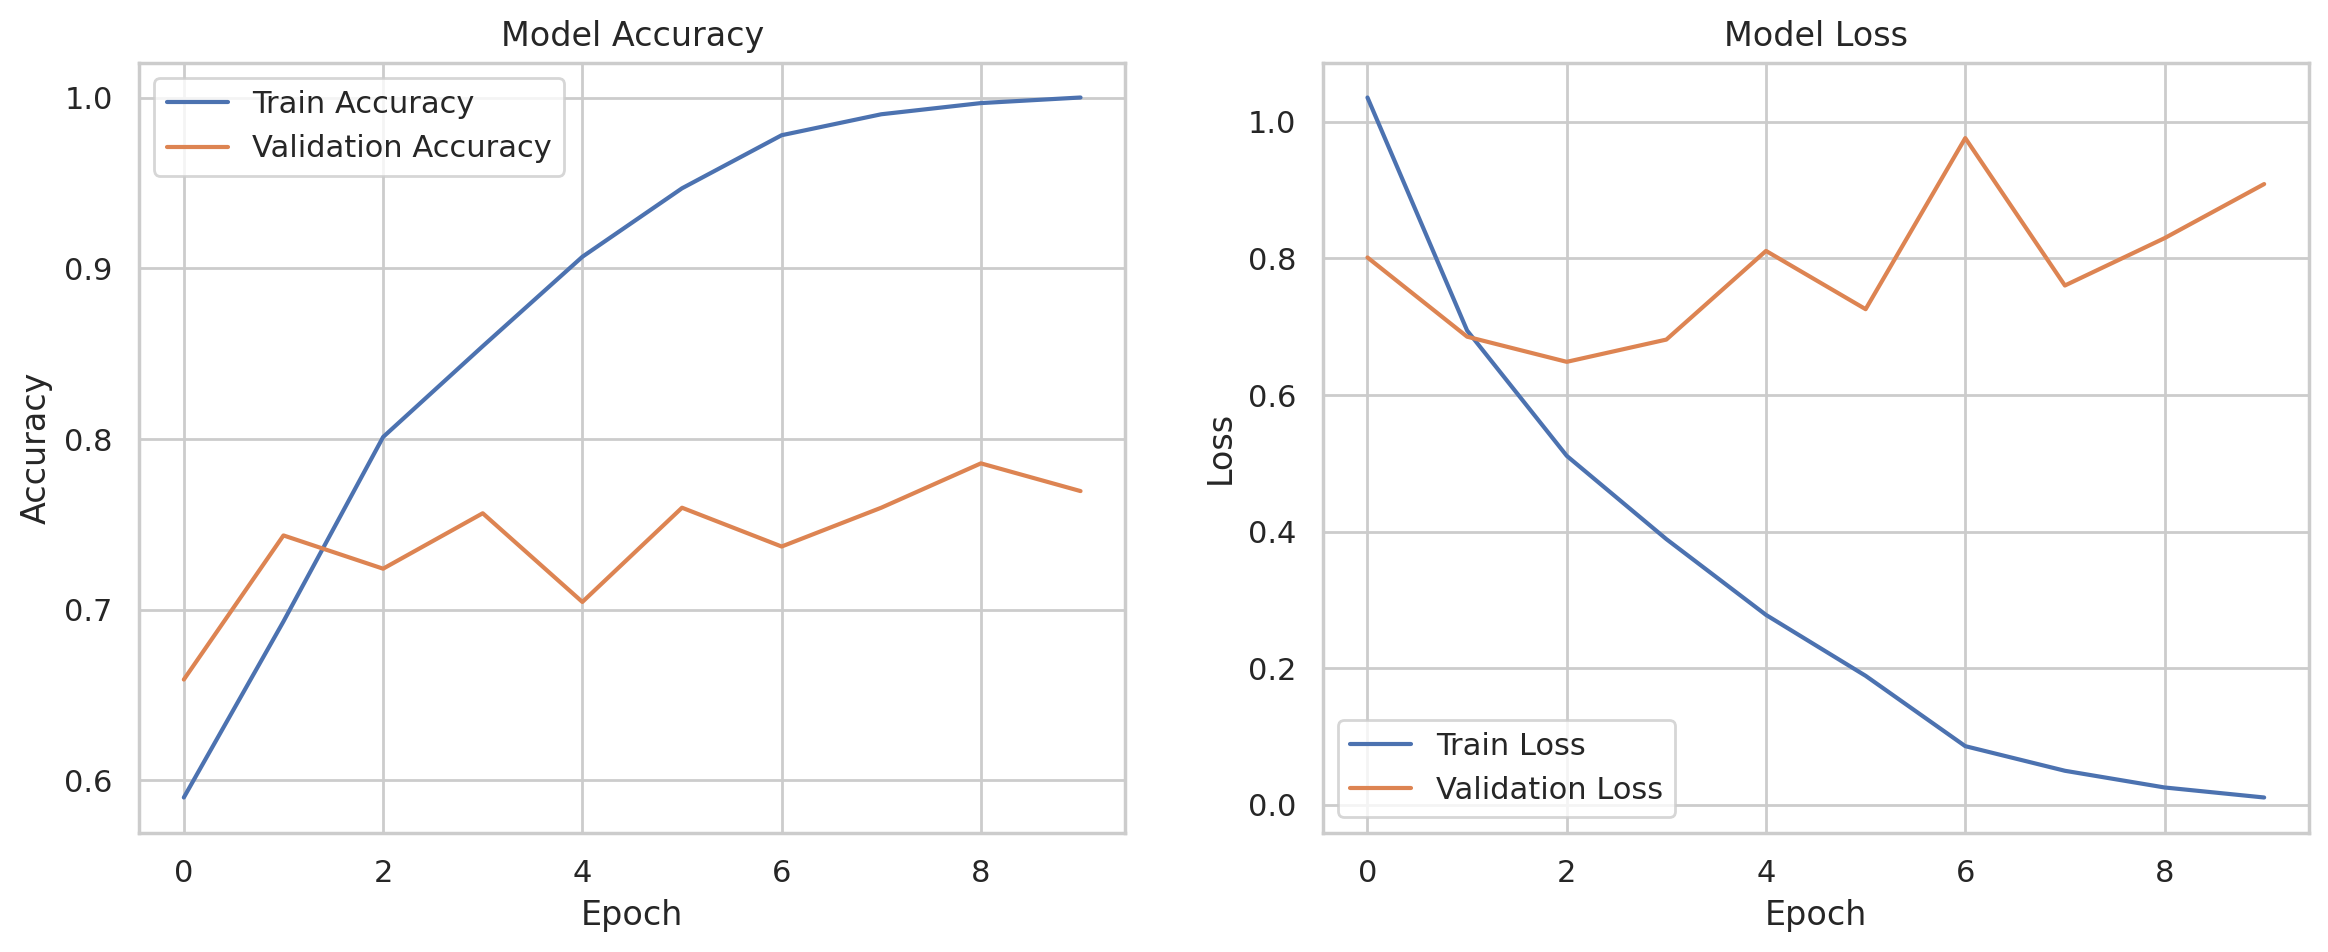

In [77]:
# Plot training & validation accuracy and loss curves
plt.figure(figsize=(14,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(training_history.history['accuracy'], label='Train Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(training_history.history['loss'], label='Train Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Observations from the CNN Base Model

- A `~77%` test accuracy is similarly respectable but not perfect.

- The model performs very well on class 0 (probably Bach) with precision and recall both high.

- Classes 1, 2, and 3 have comparatively lower precision and recall, class 2 (maybe Chopin?) having low recall (0.21) and f1 (0.32).

- The model clearly predicts many classes with class 3 as the predicted label (there's a lot of label confusion that suggests many misclassifications into class 3).

- This can depend on class imbalance or not enough features for those composers.

- Because of class imbalance, we got such plateaued graphs for validation accuracy and validation loss.

## CNN Model with Hyperparameter Tuning / Optimization

### Best Model

In [80]:
def build_model(hp):
    # Map string keys to actual kernel size tuples
    kernel_size_map = {
        '3x1': (3, 1),
        '3x3': (3, 3),
        '5x1': (5, 1)
    }
    
    conv1_kernel_choice = hp.Choice('conv1_kernel', ['3x1', '3x3', '5x1'])
    conv2_kernel_choice = hp.Choice('conv2_kernel', ['3x1', '3x3', '5x1'])
    conv3_kernel_choice = hp.Choice('conv3_kernel', ['3x1', '3x3', '5x1'])

    model = Sequential()
    model.add(
        Conv2D(
            filters=hp.Int('conv1_filters', 16, 64, step=16),
            kernel_size=kernel_size_map[conv1_kernel_choice],
            activation='relu',
            input_shape=(DESIRED_HEIGHT, 7, 1)
        )
    )
    model.add(MaxPooling2D((2,1)))

    model.add(
        Conv2D(
            filters=hp.Int('conv2_filters', 32, 128, step=32),
            kernel_size=kernel_size_map[conv2_kernel_choice],
            activation='relu'
        )
    )
    model.add(MaxPooling2D((2,1)))

    model.add(
        Conv2D(
            filters=hp.Int('conv3_filters', 64, 256, step=64),
            kernel_size=kernel_size_map[conv3_kernel_choice],
            activation='relu'
        )
    )
    model.add(Flatten())

    model.add(Dense(units=hp.Int('dense_units', 32, 128, step=32), activation='relu'))

    if hp.Boolean('dropout'):
        model.add(Dropout(rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))

    model.add(Dense(num_composer_classes, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [81]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='composer_cnn_tuning',
    project_name='midi_cnn'
)

In [82]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
conv1_kernel (Choice)
{'default': '3x1', 'conditions': [], 'values': ['3x1', '3x3', '5x1'], 'ordered': False}
conv2_kernel (Choice)
{'default': '3x1', 'conditions': [], 'values': ['3x1', '3x3', '5x1'], 'ordered': False}
conv3_kernel (Choice)
{'default': '3x1', 'conditions': [], 'values': ['3x1', '3x3', '5x1'], 'ordered': False}
conv1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_val

In [84]:
tuner.search(
    X_train_final, y_train_encoded,
    epochs=10,
    validation_data=(X_test_final, y_test_encoded),
    batch_size=32
)

Trial 10 Complete [00h 00m 31s]
val_accuracy: 0.7402597665786743

Best val_accuracy So Far: 0.801948070526123
Total elapsed time: 00h 06m 26s


In [86]:
tuner.results_summary()

Results summary
Results in composer_cnn_tuning/midi_cnn
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
conv1_kernel: 3x1
conv2_kernel: 3x1
conv3_kernel: 5x1
conv1_filters: 16
conv2_filters: 64
conv3_filters: 192
dense_units: 96
dropout: True
learning_rate: 0.0008508593738548981
dropout_rate: 0.4
Score: 0.801948070526123

Trial 00 summary
Hyperparameters:
conv1_kernel: 3x1
conv2_kernel: 3x3
conv3_kernel: 3x1
conv1_filters: 48
conv2_filters: 128
conv3_filters: 64
dense_units: 64
dropout: True
learning_rate: 0.0007019274138248607
dropout_rate: 0.2
Score: 0.7824675440788269

Trial 05 summary
Hyperparameters:
conv1_kernel: 5x1
conv2_kernel: 3x3
conv3_kernel: 3x3
conv1_filters: 64
conv2_filters: 32
conv3_filters: 64
dense_units: 64
dropout: False
learning_rate: 0.0024351489061066756
dropout_rate: 0.4
Score: 0.7824675440788269

Trial 06 summary
Hyperparameters:
conv1_kernel: 5x1
conv2_kernel: 5x1
conv3_kernel: 3x1
conv1_filters: 32
co

In [92]:
# Retrieve the best model and retrain if needed
best_model = tuner.get_best_models(num_models=1)[0]

In [93]:
best_model

<Sequential name=sequential, built=True>

In [94]:
test_loss, test_acc = best_model.evaluate(X_test_final, y_test_encoded)
print(f"Test Accuracy: {test_acc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8951 - loss: 0.2711
Test Accuracy: 0.801948070526123


In [95]:
predictions = best_model.predict(X_test_final)
predicted_classes = np.argmax(predictions, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [98]:
print(" === Finetuned CNN Classification Report === \n")
print(classification_report(y_test_encoded, predicted_classes))

 === Finetuned CNN Classification Report === 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       185
           1       0.50      0.40      0.44        43
           2       0.42      0.36      0.38        28
           3       0.62      0.79      0.69        52

    accuracy                           0.80       308
   macro avg       0.63      0.63      0.62       308
weighted avg       0.80      0.80      0.80       308



### Handle Class Imbalance

In [105]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))

history_class_imbalance = best_model.fit(
    X_train_final, y_train_encoded,
    epochs=10,
    validation_data=(X_test_final, y_test_encoded),
    batch_size=32,
    class_weight=class_weights_dict
)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9491 - loss: 0.1944 - val_accuracy: 0.7760 - val_loss: 0.7686
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9577 - loss: 0.1709 - val_accuracy: 0.7825 - val_loss: 0.6793
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9655 - loss: 0.1471 - val_accuracy: 0.7825 - val_loss: 0.7129
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9584 - loss: 0.1283 - val_accuracy: 0.7825 - val_loss: 0.6964
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9477 - loss: 0.1417 - val_accuracy: 0.7662 - val_loss: 0.6896
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.9732 - loss: 0.1016 - val_accuracy: 0.8052 - val_loss: 0.7341
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9701 - loss: 0.1098 - val_accuracy: 0.7792 - val_loss: 0.6963
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9556 - loss: 0.1767 - val_accuracy: 0.7

In [106]:
test_loss, test_acc = best_model.evaluate(X_test_final, y_test_encoded)
print(f"Test Accuracy: {test_acc}")

predictions = best_model.predict(X_test_final)
predicted_classes = np.argmax(predictions, axis=1)

print("\n\n === Finetuned CNN Classification Report with Class imbalance handling === \n")
print(classification_report(y_test_encoded, predicted_classes))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8903 - loss: 0.4351
Test Accuracy: 0.7694805264472961
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 === Finetuned CNN Classification Report with Class imbalance handling === 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       185
           1       0.46      0.56      0.51        43
           2       0.50      0.29      0.36        28
           3       0.54      0.50      0.52        52

    accuracy                           0.77       308
   macro avg       0.61      0.58      0.58       308
weighted avg       0.76      0.77      0.76       308



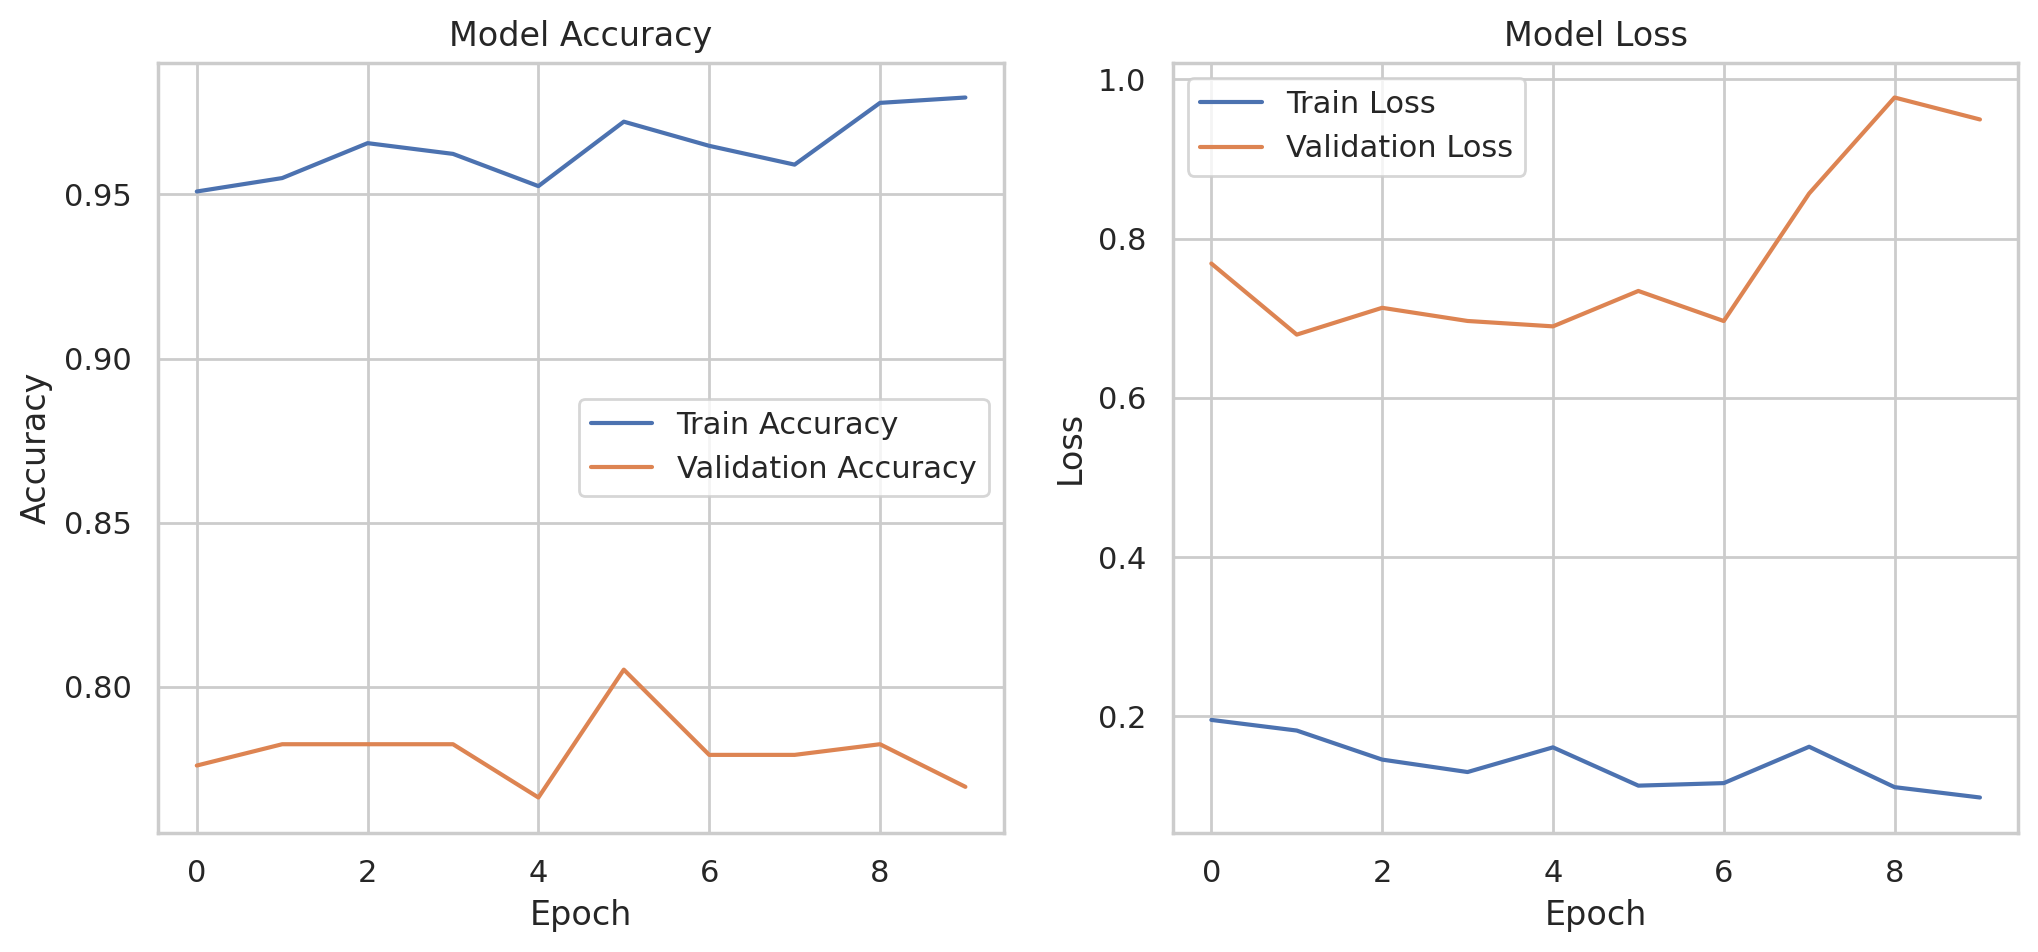

In [107]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_class_imbalance.history['accuracy'], label='Train Accuracy')
plt.plot(history_class_imbalance.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_class_imbalance.history['loss'], label='Train Loss')
plt.plot(history_class_imbalance.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## CNN with Regularization, DropOut and EarlyStopping criterion

In [132]:
weight_decay = 1e-5  # smaller L2 regularization

model = Sequential([
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=X_train_final.shape[1:], 
           kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),
    
    Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),
    
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    Dropout(0.3),
    
    Dense(num_composer_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # higher LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    X_train_final, y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_final, y_test_encoded),
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.3064 - loss: 4.3785 - val_accuracy: 0.1883 - val_loss: 1.5377 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5535 - loss: 1.2710 - val_accuracy: 0.1429 - val_loss: 3.4533 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.6597 - loss: 0.9475 - val_accuracy: 0.1396 - val_loss: 9.6931 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6902 - loss: 0.8656 - val_accuracy: 0.1364 - val_loss: 11.5054 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7873 - loss: 0.6616 - val_accuracy: 0.1429 - val_loss: 14.7081 - learning_rate: 0.0010
Epoch 6/100
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8210 - loss: 0.5302
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.8205 - loss: 0.5

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


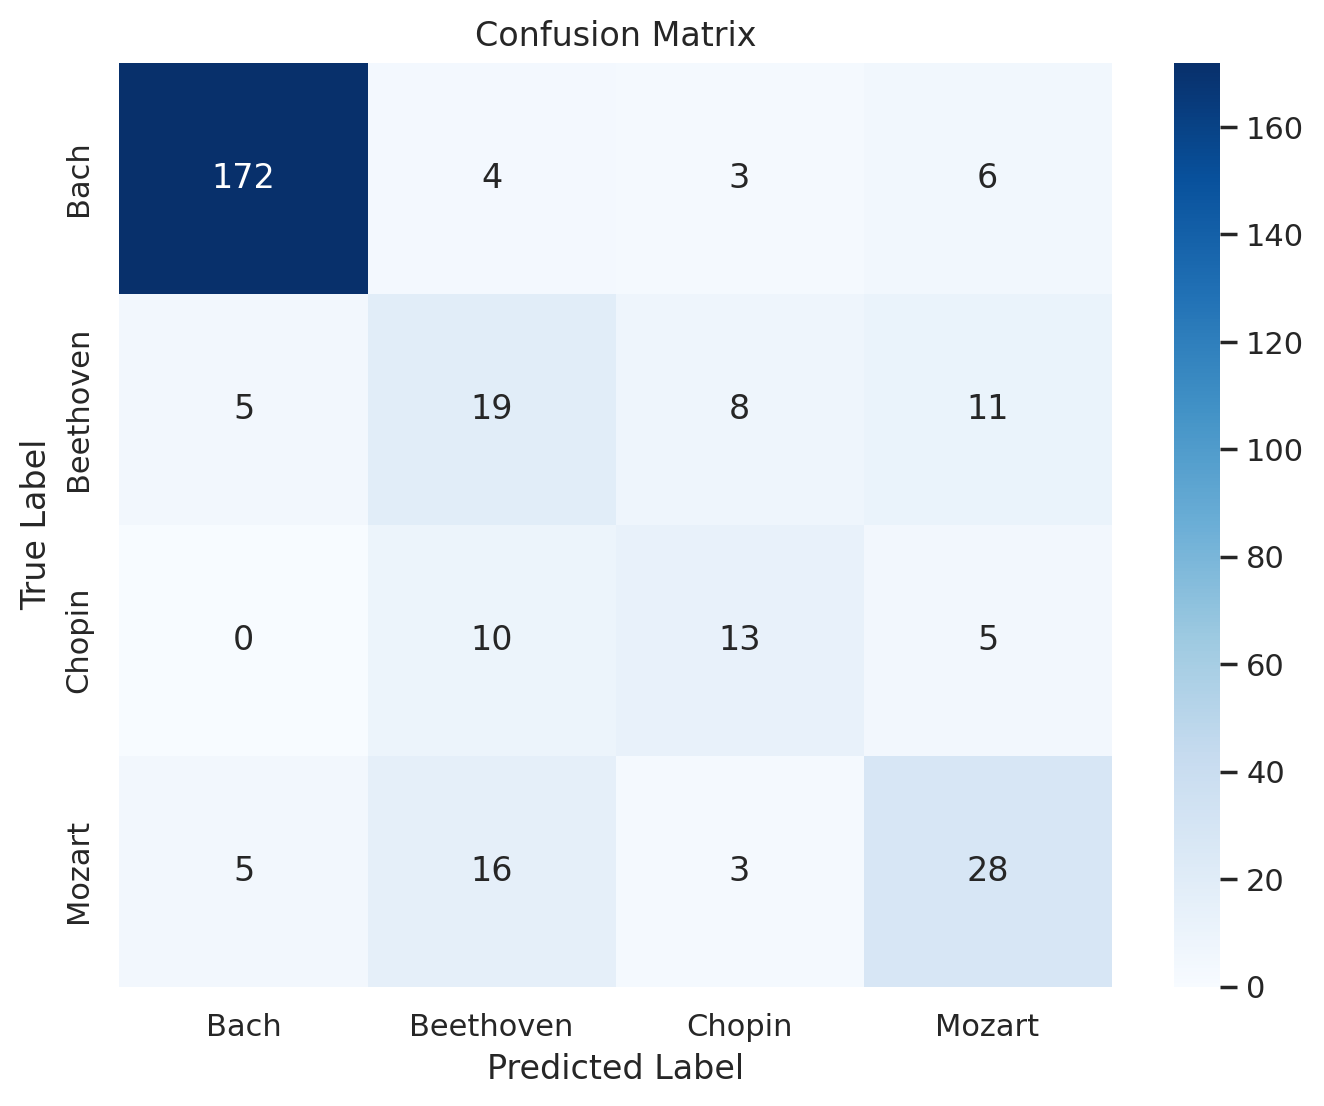


 === Classification Report with Regularization, Early Stopping and DropOut ===

              precision    recall  f1-score   support

        Bach       0.95      0.93      0.94       185
   Beethoven       0.39      0.44      0.41        43
      Chopin       0.48      0.46      0.47        28
      Mozart       0.56      0.54      0.55        52

    accuracy                           0.75       308
   macro avg       0.59      0.59      0.59       308
weighted avg       0.76      0.75      0.76       308



In [138]:
# Predict classes for test data
pred_probs = model.predict(X_test_final)
pred_classes = np.argmax(pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_encoded, pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TARGET_COMPOSERS, yticklabels=TARGET_COMPOSERS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\n === Classification Report with Regularization, Early Stopping and DropOut ===\n")
print(classification_report(y_test_encoded, pred_classes, target_names=TARGET_COMPOSERS))

## LSTM Base Model

In [142]:
# Prepare LSTM input by removing the last dimension (channel=1)
x_train_lstm = np.squeeze(X_train_final, axis=-1)
x_test_lstm = np.squeeze(X_test_final, axis=-1)

In [143]:
x_train_lstm.shape, x_test_lstm.shape

((1222, 168, 7), (308, 168, 7))

In [147]:
sequence_length = x_train_lstm.shape[1]
feature_dim = x_train_lstm.shape[2]
num_composers = len(TARGET_COMPOSERS)

# Build LSTM model
composer_lstm_model = Sequential([
    LSTM(128, input_shape=(sequence_length, feature_dim), return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(num_composers, activation='softmax')
])

In [148]:
composer_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [149]:
composer_lstm_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 168, 128)       │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 168, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,732 (819.27 KB)

 Trainable params: 209,732 (819.27 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
# Train the model
training_history = composer_lstm_model.fit(
    x_train_lstm, y_train_encoded,
    epochs=20,
    batch_size=32,
    validation_data=(x_test_lstm, y_test_encoded)
)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 390ms/step - accuracy: 0.5609 - loss: 1.1934 - val_accuracy: 0.6104 - val_loss: 1.0045
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 361ms/step - accuracy: 0.6273 - loss: 0.9682 - val_accuracy: 0.5487 - val_loss: 1.0147
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.6409 - loss: 0.9473 - val_accuracy: 0.6591 - val_loss: 0.8467
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 364ms/step - accuracy: 0.6454 - loss: 0.8379 - val_accuracy: 0.6364 - val_loss: 0.8785
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 368ms/step - accuracy: 0.6352 - loss: 0.8777 - val_accuracy: 0.4903 - val_loss: 1.0497
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.5766 - loss: 0.9336 - val_accuracy: 0.6234 - val_loss: 0.8592
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.6360 - loss: 0.8811 - val_accuracy: 0.6364 - val_loss: 0.8118
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 384ms/step - accuracy: 0.6342 - loss: 0.8870 - val_accu

In [151]:
# Evaluate on test set
test_loss, test_accuracy = composer_lstm_model.evaluate(x_test_lstm, y_test_encoded)
print(f"Test accuracy: {test_accuracy:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.8411 - loss: 0.4418
Test accuracy: 0.7143


In [152]:
# Predict on test set
test_predictions = composer_lstm_model.predict(x_test_lstm)
predicted_labels = np.argmax(test_predictions, axis=1)

print("\n" + "="*40)
print("        Expected Labels")
print("="*40)
print(y_test_encoded)
print("\n")

print("="*40)
print("        Predicted Labels")
print("="*40)
print(predicted_labels)
print("\n")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 179ms/step

        Expected Labels
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3]


        Predicted Labels
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 3 0 0 3 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 1 0 0 0 3 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0

In [155]:
classification_rep = classification_report(y_test_encoded, predicted_labels)
print("="*40)
print(" CLASSIFICATION REPORT LSTM Base Model ")
print("="*40)
print(classification_rep)

 CLASSIFICATION REPORT LSTM Base Model 
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       185
           1       0.38      0.37      0.38        43
           2       0.43      0.32      0.37        28
           3       0.44      0.46      0.45        52

    accuracy                           0.71       308
   macro avg       0.54      0.52      0.53       308
weighted avg       0.70      0.71      0.71       308



## Observations from LSTM Base Model

- A test accuracy `~71%` is reasonable, meaning the model learned some patterns.

- Precision/recall/F1 for class 0 (Bach) is high (`~90%`), but other composers are much lower (`~40%`). This fits with your class imbalance.

- Macro avg F1 `~0.53` tells you that the model is having a tougher time on the less represented composers.

## Finetune LSTM Model (Bidirectional LSTM) with multiple techniques along with handling class-imbalance

In [158]:
# Compute class weights to address imbalance
class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}

# Build improved LSTM model with Bidirectional and recurrent dropout
composer_lstm_model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2), input_shape=(sequence_length, feature_dim)),
    Dropout(0.3),
    Bidirectional(LSTM(128, recurrent_dropout=0.2)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_composers, activation='softmax')
])

composer_lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

composer_lstm_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 168, 256)       │       139,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 168, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,212 (2.10 MB)

 Trainable params: 550,212 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [160]:
# Setup callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model with class weights and callbacks
history = composer_lstm_model.fit(
    x_train_lstm, y_train_encoded,
    validation_data=(x_test_lstm, y_test_encoded),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.4378 - loss: 1.3022 - val_accuracy: 0.5812 - val_loss: 1.1001 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 902ms/step - accuracy: 0.5434 - loss: 1.2135 - val_accuracy: 0.6299 - val_loss: 0.9992 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 36s 915ms/step - accuracy: 0.5854 - loss: 1.1066 - val_accuracy: 0.6039 - val_loss: 0.9365 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 909ms/step - accuracy: 0.5603 - loss: 1.1982 - val_accuracy: 0.6234 - val_loss: 0.9616 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 35s 908ms/step - accuracy: 0.6125 - loss: 1.0345 - val_accuracy: 0.6266 - val_loss: 0.9247 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 880ms/step - accuracy: 0.6636 - loss: 0.9608 - val_accuracy: 0.6851 - val_loss: 0.8109 - learning_rate: 0.0010
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 879ms/step - accuracy: 0.6734 - loss: 0.907

In [163]:
# Evaluate the finetuned model
test_loss, test_acc = composer_lstm_model.evaluate(x_test_lstm, y_test_encoded)
print(f"Test accuracy: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8343 - loss: 0.3885
Test accuracy: 0.7500


In [164]:
y_pred_probs = composer_lstm_model.predict(x_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report with finetuned LSTM:\n", classification_report(y_test_encoded, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Classification Report with finetuned LSTM:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       185
           1       0.44      0.49      0.46        43
           2       0.50      0.68      0.58        28
           3       0.52      0.50      0.51        52

    accuracy                           0.75       308
   macro avg       0.60      0.64      0.62       308
weighted avg       0.77      0.75      0.76       308



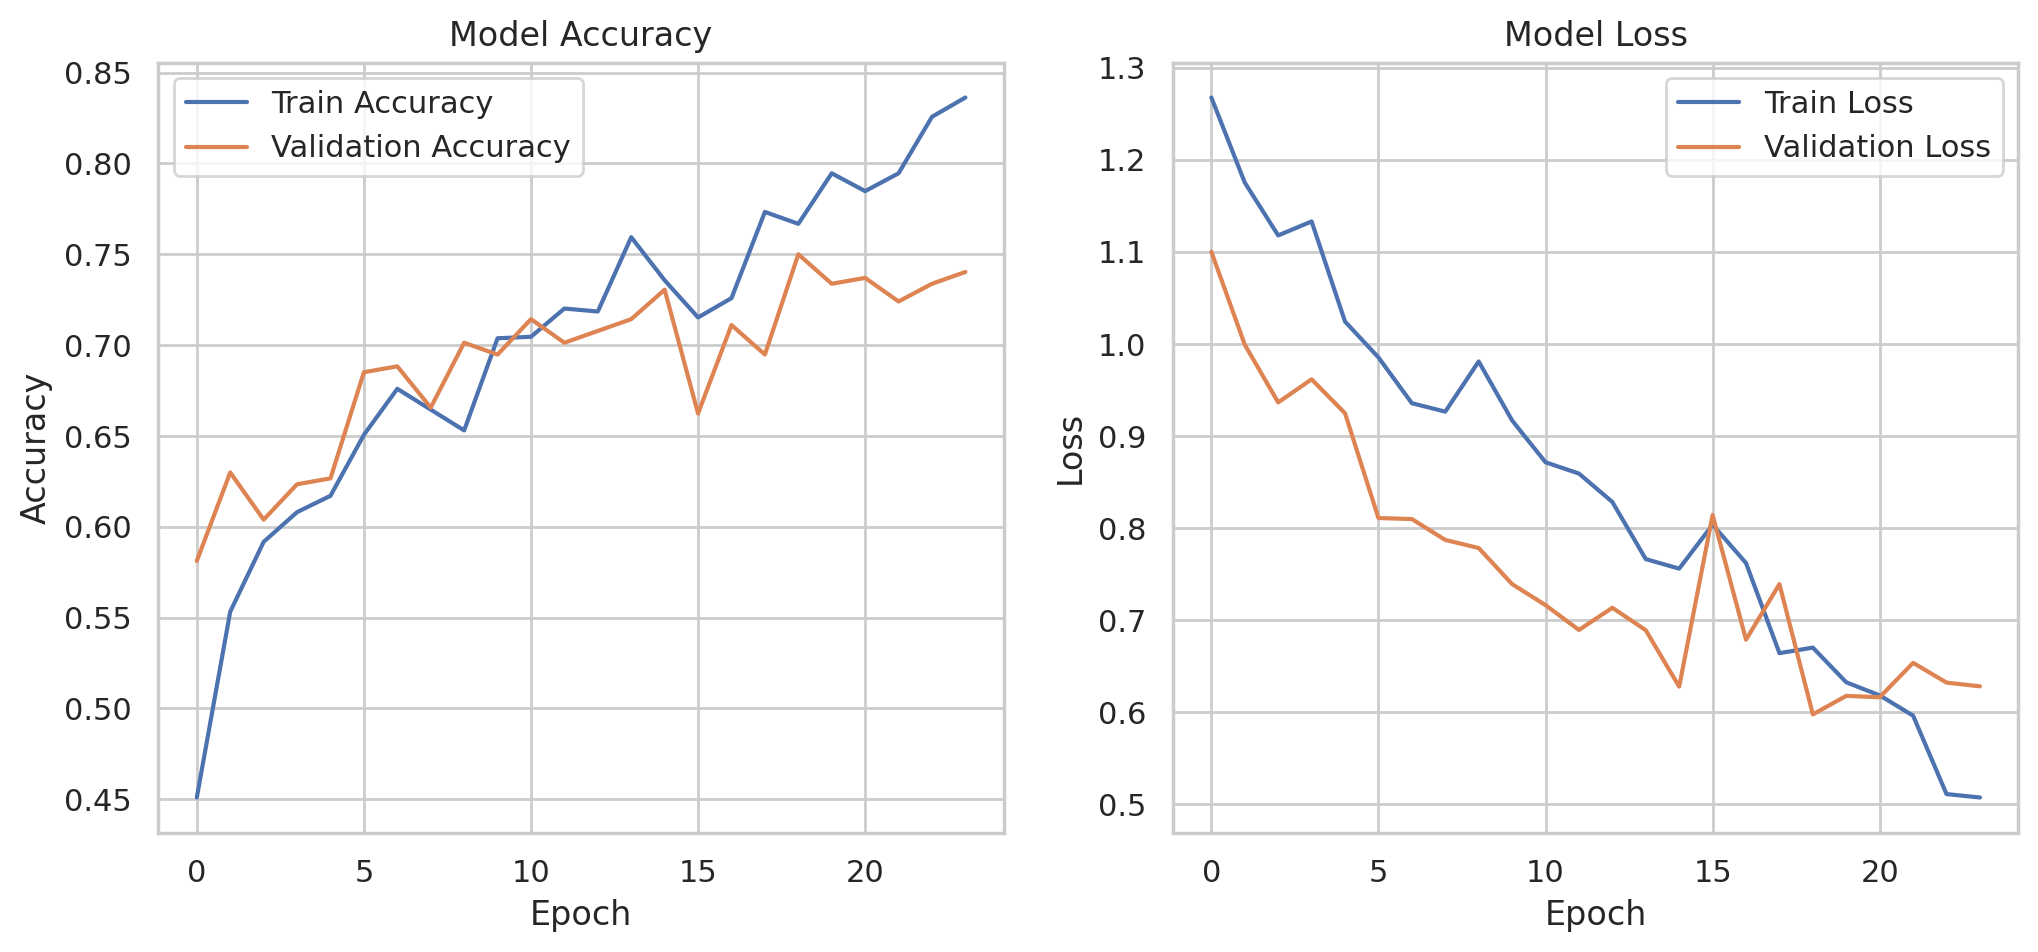

In [165]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Observations from finetuned LSTM (Bidirectional LSTM)

- Test accuracy: `75%` (up from `~71%`).

- Much better balanced class-wise recall and f1-scores and more improvement in the minority classes (e.g. class 2 recall increased from 0.32 to 0.68).

- Stable training with early stopping and LR reduction.

- The introduction of `class_weight` for class imbalance handling allowed minority classes to be more effectively focused on.

- When using Bidirectional LSTMs with recurrent dropout, we have better ability to capture context and regularize overfitting.

- The use of early stopping combined with ReduceLROnPlateau allowed the model to train efficiently without overfitting or plateauing too soon.

- Precision/recall for the smaller classes remain as an area for improvement, and will continue to be something to investigate further.